# The following Class is used to normalize the solar inputs based on the longitude, latitude, cell type and capacity, tilt, asmuth, and the specific day of the year.

In [8]:
import numpy as np

class Preprocess:
    def __init__(self, latitude, longitude):
        """
            Latitude in degrees (+ north, - south)
            Longitude in degrees (+ east, - west)
        """
        self.latitude = latitude
        self.longitude = longitude

    def H_prime(self, day_of_year):
        """
        day_of_year: int (1-365 or 366)
        This is the average solar constant adjusted for the day of the year, this is based on the spherical orbit of the earth with respect to the sun. 
        It is used to approximate the solar irradiation when there is no clouds and the sun is at a normal angle (12 O'clock or midday).
        """
        H0 = 1367 # W/m² (average solar constant)
        H0_prime = H0 * (1 + 0.033 * np.cos(np.radians(360 * day_of_year / 365)))
        return H0_prime
    def estimate_solar_irradiation(self, day_of_year, hour_local, tilt_deg=28, azimuth_deg=220):
        """Estimate solar irradiation (W/m²) on a tilted surface.
        day_of_year: int (1-365 or 366)
        hour_local: local time in 24 hours format, e.g., 13.5 = 1:30 PM
        tilt_deg: tilt angle of the panel from horizontal (degrees), 0° = horizontal
        azimuth_deg: azimuth angle of the panel (degrees), 0° = North, 90° = East, 180° = South, 270° = West
        returns the estimated solar irradiation (W/m²)
        """
    
        # Get corrected solar constant
        H0 = self.H_prime(day_of_year)

        # Convert to radians
        phi = np.radians(self.latitude)
        tilt = np.radians(tilt_deg)
        azimuth = np.radians(azimuth_deg)

        # Solar declination angle (radians)
        delta = 23.45 * np.sin(np.radians(360/365 * (day_of_year - 81)))
        delta = np.radians(delta)

        # Equation of Time (minutes)
        # B = 360/365 * (day_of_year - 81) is the angle in degrees
        # EoT = 9.87 * sin(2B) - 7.53 * cos(B) - 1.5 * sin(B)
        # where B is in degrees
        # EoT is the difference between solar time and clock time
        # due to the elliptical shape of the Earth's orbit and axial tilt, 81st day of the year is around March 21st which is the equinox
        B = 360/365 * (day_of_year - 81)
        EoT = 9.87 * np.sin(np.radians(2*B)) - 7.53 * np.cos(np.radians(B)) - 1.5 * np.sin(np.radians(B))

        # Time correction factor (minutes)
        timezone_longitude = round(self.longitude / 15) * 15
        time_correction = 4 * (self.longitude - timezone_longitude) + EoT

        # Solar time (hours)
        solar_time = hour_local + time_correction / 60

        # Hour angle omega (radians)
        omega = np.radians(15 * (solar_time - 12))

        # Cosine of solar zenith angle (for reference)
        cosZ = np.sin(phi) * np.sin(delta) + np.cos(phi) * np.cos(delta) * np.cos(omega)
        cosZ = max(cosZ, 0)

        if cosZ == 0:
            return 0  # Sun is below horizon, no irradiation

        # Solar azimuth and solar elevation
        sin_alpha = np.sin(phi) * np.sin(delta) + np.cos(phi) * np.cos(delta) * np.cos(omega)  # sin of solar elevation angle
        alpha = np.arcsin(sin_alpha)  # solar elevation angle in radians

        # Solar azimuth angle (γs)
        cos_azimuth = (np.sin(delta) - np.sin(phi) * np.sin(alpha)) / (np.cos(phi) * np.cos(alpha))
        cos_azimuth = np.clip(cos_azimuth, -1, 1)  # numerical safety
        solar_azimuth = np.arccos(cos_azimuth)  # radians

        if omega > 0:  # afternoon
            solar_azimuth = 2*np.pi - solar_azimuth

        # Angle of incidence (θ) between sun rays and panel normal
        cos_theta = (
            np.sin(delta) * np.sin(phi) * np.cos(tilt)
            - np.sin(delta) * np.cos(phi) * np.sin(tilt) * np.cos(azimuth)
            + np.cos(delta) * np.cos(phi) * np.cos(tilt) * np.cos(omega)
            + np.cos(delta) * np.sin(phi) * np.sin(tilt) * np.cos(azimuth) * np.cos(omega)
            + np.cos(delta) * np.sin(tilt) * np.sin(azimuth) * np.sin(omega)
        )
        cos_theta = max(cos_theta, 0)  # No backside radiation

        # Estimate irradiation on tilted panel
        irradiation = H0 * cos_theta

        return irradiation


    def normalize(self, cell_type, num_panels, tilt_angle_deg, azimuth_deg, total_rated_capacity_kw):
        """
        Normalize the irradiation based on panel setup and system specs.

        Args:
            cell_type (str): Type of solar cell ('mono', 'poly', 'thinfilm')
            num_panels (int): Number of panels
            tilt_angle_deg (float): Tilt of the panels (degrees)
            azimuth_deg (float): Orientation of the panels (degrees from North)
            total_rated_capacity_kw (float): Total rated system capacity (kW)

        Returns:
            float: Normalized irradiation value (W/m²)
        """
        # Define typical efficiencies by cell type
        efficiencies = {
            'mono': 0.20,
            'poly': 0.17,
            'thinfilm': 0.11
        }

        # Get efficiency based on cell type
        cell_type = cell_type.lower()
        if cell_type not in efficiencies:
            raise ValueError(f"Unknown cell type '{cell_type}'. Choose from {list(efficiencies.keys())}.")
        
        efficiency = efficiencies[cell_type]

        # Calculate total panel area (in m²)
        total_rated_capacity_w = total_rated_capacity_kw * 1000  # convert kW to W
        total_area_m2 = total_rated_capacity_w / (efficiency * 1000)  # 1000 W/m² at STC

        # Irradiance normalized per m²
        normalized_irradiation = (total_rated_capacity_w / total_area_m2)  # Should give back 1000 W/m² ideally

        # Could include tilt and azimuth correction here later if needed

        return normalized_irradiation


# Create an irradiation matrix for 30 days and 12 hours
# This is used to estimate the solar irradiation for a specific location and time in perfect conditions

pre = Preprocess(latitude=34.2599, longitude=-35.8419)
irradiation=np.zeros((360,12))
for day in range(0, 30, 1):
    for time in range(0, 12, 1):
        irradiation[day,time]=pre.estimate_solar_irradiation(day, time+6, tilt_deg=30, azimuth_deg=230)



In [9]:
irradiation2=np.zeros((30,12))
for day in range(0, 29, 1):
    for time in range(0, 12, 1):
        irradiation2[day,time]=pre.estimate_solar_irradiation(day+120, time+6, tilt_deg=30, azimuth_deg=230)
irradiation2=irradiation2.flatten()

In [10]:
import pandas as pd

# Load the whether data and the PV output data from the excel file
file_path = 'Data.xlsx'  

df_weather = pd.read_excel(file_path, sheet_name=1)
df_PV_Out = pd.read_excel('Data.xlsx', sheet_name=0)
df_PV_Out = df_PV_Out.drop(columns=['Date','Hour'])

# Convert the DataFrame to a NumPy array
data_array = df_PV_Out.to_numpy()

df_weather['period_end'] = pd.to_datetime(df_weather['period_end'])

# Filter rows where time is between 06:00 and 17:00
filtered_df_weather = df_weather[df_weather['period_end'].dt.hour.between(6, 17)].drop(columns='period_end')


# Creating the Feature space and the training, validation, and testing data

In [13]:
from sklearn.model_selection import train_test_split


X = np.column_stack((filtered_df_weather.to_numpy(), irradiation2))
# Display or process the filtered DataFrame
y=df_PV_Out.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)


# Fitting first order Linear Regression, with threshold

Selected Features (mask): [ True  True False False False False False False  True False False False
 False False  True False False False  True  True  True False False  True
  True False False]
Refit model saved to 'saved_models/linear_model_filtered.pkl'
R² score (refit): 0.207076896371297

Selected Features and Coefficients:
Feature x0: Coefficient = 0.269687715456607
Feature x1: Coefficient = -2.6709341521480163
Feature x8: Coefficient = -0.2524223702919609
Feature x14: Coefficient = -0.5230737829839736
Feature x18: Coefficient = 0.7276068216667111
Feature x19: Coefficient = -0.5480047196778264
Feature x20: Coefficient = 0.9208554837723806
Feature x23: Coefficient = -0.2284532651881758
Feature x24: Coefficient = 0.3291311825957443

Regression Equation:
y = 0.270*x0 + -2.671*x1 + -0.252*x8 + -0.523*x14 + 0.728*x18 + -0.548*x19 + 0.921*x20 + -0.228*x23 + 0.329*x24


C:\Users\Administrator\AppData\Local\Temp\ipykernel_25872\3910012756.py:70: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test_time_index = pd.date_range(start=start_time, periods=len(y_test2), freq='H')


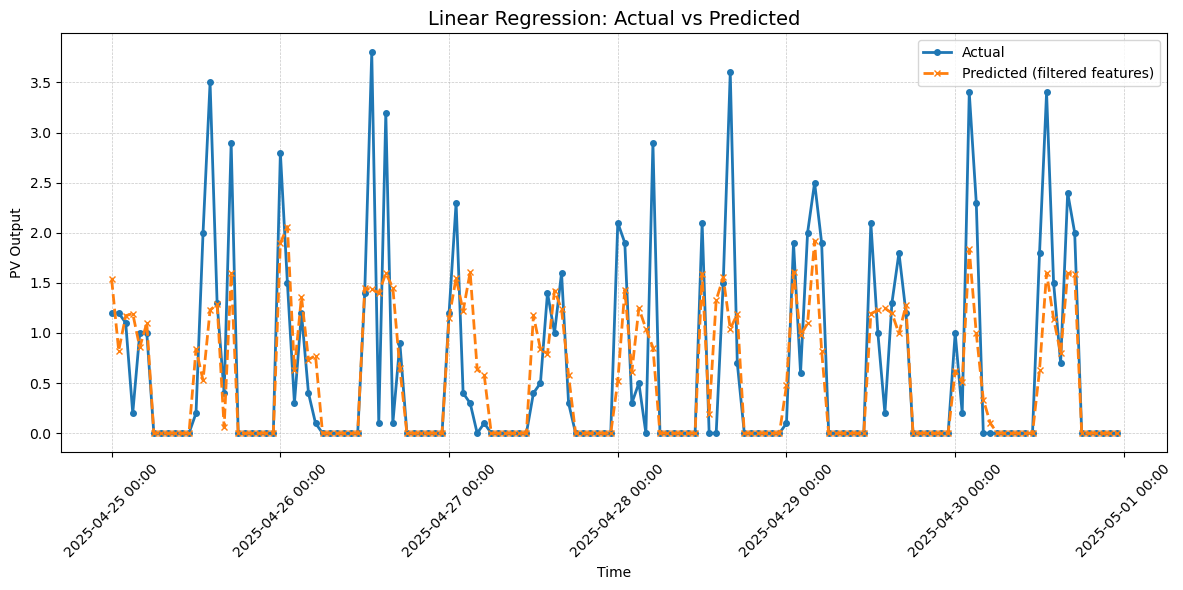

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.metrics import r2_score
import os


# Fitting the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Masking features based on coefficients
coef_mask = np.abs(lr.coef_) > 1e-1
coef_mask2 = coef_mask
coef_mask = coef_mask.flatten()
print("Selected Features (mask):", coef_mask)

# Filtering X to keep only important features
X_train_filtered = X_train[:, coef_mask]
X_test_filtered = X_test[:, coef_mask]

# Refitting the model using filtered features
lr_refit = LinearRegression()
lr_refit.fit(X_train_filtered, y_train)

# Saving the refit model as a pickle file
os.makedirs("saved_models", exist_ok=True)
with open("saved_models/linear_model_filtered.pkl", "wb") as f:
    pickle.dump(lr_refit, f)
print("Refit model saved to 'saved_models/linear_model_filtered.pkl'")

# Predicting on test data
y_pred = lr_refit.predict(X_test_filtered)

# R² score
print("R² score (refit):", r2_score(y_test, y_pred))

# Printing selected coefficients and feature names
print("\nSelected Features and Coefficients:")
selected_features = np.where(coef_mask2)[0]
selected_coefs = lr.coef_[coef_mask2]

try:
    feature_names = X_train.columns  # If using pandas DataFrame
    for feature_name, coef in zip(feature_names[selected_features], selected_coefs):
        print(f"{feature_name}: Coefficient = {coef}")
except AttributeError:
    for feature_idx, coef in zip(selected_features, selected_coefs):
        print(f"Feature x{feature_idx}: Coefficient = {coef}")

print("\nRegression Equation:")
if 'feature_names' in locals():
    equation = "y = " + " + ".join([f"{coef:.3f}*{name}" for name, coef in zip(feature_names[selected_features], selected_coefs)])
else:
    equation = "y = " + " + ".join([f"{coef:.3f}*x{idx}" for idx, coef in zip(selected_features, selected_coefs)])
print(equation)

#Converting data to days by appending zeros for the night hours
y_test2 = y_test.reshape(12, -1)
y_pred2 = y_pred.reshape(12, -1)
y_test2 = np.column_stack((y_test2, np.zeros_like(y_test2)))  # Append zeros
y_pred2 = np.column_stack((y_pred2, np.zeros_like(y_pred2)))  # Append zeros
y_test2 = y_test2.flatten()
y_pred2 = y_pred2.flatten()
start_time = pd.Timestamp("2025-04-25 00:00:00")
test_time_index = pd.date_range(start=start_time, periods=len(y_test2), freq='H')


# Plotting the actual vs predicted results
plt.figure(figsize=(12, 6))
plt.plot(test_time_index, y_test2, label='Actual', color='tab:blue', linewidth=2, marker='o', markersize=4)
plt.plot(test_time_index, y_pred2, label='Predicted (filtered features)', color='tab:orange', linestyle='--', linewidth=2, marker='x', markersize=4)

# Format the x-axis as dates
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

plt.title('Linear Regression: Actual vs Predicted', fontsize=14)
plt.xlabel('Time')
plt.ylabel('PV Output')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


# Fitting LR on Quadratic inputs

R² score (refit): 0.3598715431686319
Model saved to 'quadratic_filtered_model.pkl'.

 Selected Features and Coefficients:
azimuth: Coefficient = 0.991
clearsky_dhi: Coefficient = -0.886
clearsky_gti: Coefficient = 1.876
dhi: Coefficient = -2.644
dni: Coefficient = -0.610
ghi: Coefficient = -0.876
gti: Coefficient = 1.176
relative_humidity: Coefficient = 0.622
wind_direction_100m: Coefficient = -0.565
Perfect_irradiation: Coefficient = -1.412
air_temp precipitable_water: Coefficient = -0.677
air_temp precipitation_rate: Coefficient = 1.572
air_temp snow_depth: Coefficient = -1.499
air_temp wind_speed_100m: Coefficient = 1.641
air_temp wind_speed_10m: Coefficient = -1.112
albedo clearsky_dhi: Coefficient = -2.094
albedo cloud_opacity: Coefficient = -1.243
albedo dhi: Coefficient = -1.622
albedo dni: Coefficient = -0.750
albedo ghi: Coefficient = 0.618
albedo gti: Coefficient = 0.849
albedo relative_humidity: Coefficient = -1.582
albedo wind_direction_10m: Coefficient = 0.827
clearsky_dhi

C:\Users\Administrator\AppData\Local\Temp\ipykernel_25872\4279682975.py:66: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test_time_index = pd.date_range(start=start_time, periods=len(y_test2), freq='H')


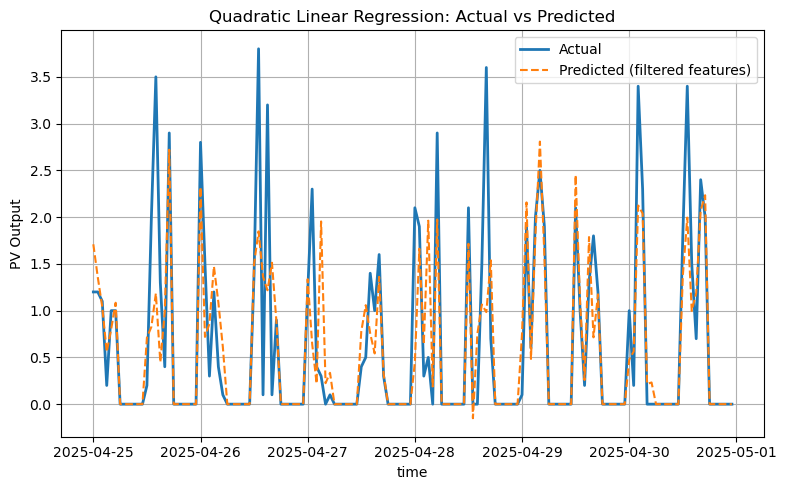


Regression Equation:
y = 0.991*azimuth + -0.886*clearsky_dhi + 1.876*clearsky_gti + -2.644*dhi + -0.610*dni + -0.876*ghi + 1.176*gti + 0.622*relative_humidity + -0.565*wind_direction_100m + -1.412*Perfect_irradiation + -0.677*air_temp precipitable_water + 1.572*air_temp precipitation_rate + -1.499*air_temp snow_depth + 1.641*air_temp wind_speed_100m + -1.112*air_temp wind_speed_10m + -2.094*albedo clearsky_dhi + -1.243*albedo cloud_opacity + -1.622*albedo dhi + -0.750*albedo dni + 0.618*albedo ghi + 0.849*albedo gti + -1.582*albedo relative_humidity + 0.827*albedo wind_direction_10m + -0.698*clearsky_dhi snow_water_equivalent + 0.767*cloud_opacity precipitation_rate + 0.698*cloud_opacity wind_speed_100m + -1.070*cloud_opacity wind_speed_10m + 0.633*dewpoint_temp precipitable_water + 1.881*dewpoint_temp precipitation_rate + -1.552*dewpoint_temp wind_speed_10m + -0.896*dhi snow_water_equivalent + -0.992*dni snow_water_equivalent + 0.561*ghi wind_speed_100m + -0.711*ghi wind_speed_10m + 

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import pickle


# Quadratic Feature Engineering
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_quad = poly.fit_transform(X_train)
X_test_quad = poly.transform(X_test)
# Ensure target vectors are 1D
y_train = y_train.ravel()
y_test = y_test.ravel()
#Fitting the Model
lr = LinearRegression()
lr.fit(X_train_quad, y_train)
# Masking features based on coefficients
coef_mask = np.abs(lr.coef_) > 0.5
coef_mask2 = coef_mask.copy()
X_train_filtered = X_train_quad[:, coef_mask]
X_test_filtered = X_test_quad[:, coef_mask]

# Refitting the Model with Filtered Features
lr_refit = LinearRegression()
lr_refit.fit(X_train_filtered, y_train)

# Testing and Predicting
y_pred = lr_refit.predict(X_test_filtered)
print("R² score (refit):", r2_score(y_test, y_pred))

#Saving the model
with open("quadratic_filtered_model.pkl", "wb") as f:
    pickle.dump(lr_refit, f)
print("Model saved to 'quadratic_filtered_model.pkl'.")

#Printing the selected features and coefficients
feature_names_raw = [
    'air_temp', 'albedo', 'azimuth', 'clearsky_dhi', 'clearsky_dni', 'clearsky_ghi', 'clearsky_gti',
    'cloud_opacity', 'dewpoint_temp', 'dhi', 'dni', 'ghi', 'gti', 'precipitable_water', 'precipitation_rate',
    'relative_humidity', 'surface_pressure', 'snow_depth', 'snow_water_equivalent', 'snow_soiling_rooftop',
    'snow_soiling_ground', 'wind_direction_100m', 'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m',
    'zenith', 'Perfect_irradiation'
]

# Get feature names for polynomial terms
poly_feature_names = poly.get_feature_names_out(feature_names_raw)

selected_feature_names = np.array(poly_feature_names)[coef_mask2]
selected_coefs = lr.coef_[coef_mask2]

print("\n Selected Features and Coefficients:")
for name, coef in zip(selected_feature_names, selected_coefs):
    print(f"{name}: Coefficient = {coef:.3f}")

#Converting data to days by appending zeros for the night hours
y_test2 = y_test.reshape(12, -1)
y_pred2 = y_pred.reshape(12, -1)
y_test2 = np.column_stack((y_test2, np.zeros_like(y_test2)))  # Append zeros
y_pred2 = np.column_stack((y_pred2, np.zeros_like(y_pred2)))  # Append zeros
y_test2 = y_test2.flatten()
y_pred2 = y_pred2.flatten()
start_time = pd.Timestamp("2025-04-25 00:00:00")
test_time_index = pd.date_range(start=start_time, periods=len(y_test2), freq='H')

# Plotting the actual vs predicted results
plt.figure(figsize=(8, 5))
plt.plot(test_time_index,y_test2, label='Actual', linewidth=2)
plt.plot(test_time_index,y_pred2, label='Predicted (filtered features)', linestyle='--')
plt.title('Quadratic Linear Regression: Actual vs Predicted')
plt.xlabel('time')
plt.ylabel('PV Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.preprocessing import PolynomialFeatures

# Step 1: Get all feature names from the PolynomialFeatures object
feature_names_quad = poly.get_feature_names_out(input_features=feature_names_raw)

# Step 2: Filter feature names and coefficients using the selected mask
filtered_names = feature_names_quad[coef_mask]
filtered_coefs = lr.coef_[coef_mask]

# Step 3: Build the equation string
equation = "y = " + " + ".join([
    f"{coef:.3f}*{name}" for coef, name in zip(filtered_coefs, filtered_names)
])

print("\nRegression Equation:")
print(equation)



C:\Users\Administrator\AppData\Local\Temp\ipykernel_14688\40024003.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start="2025-04-25 06:00:00", periods=min_length, freq='H')


For the Linear Regression Model:
RMSE: 0.5912
RMSE_App: 1.2238


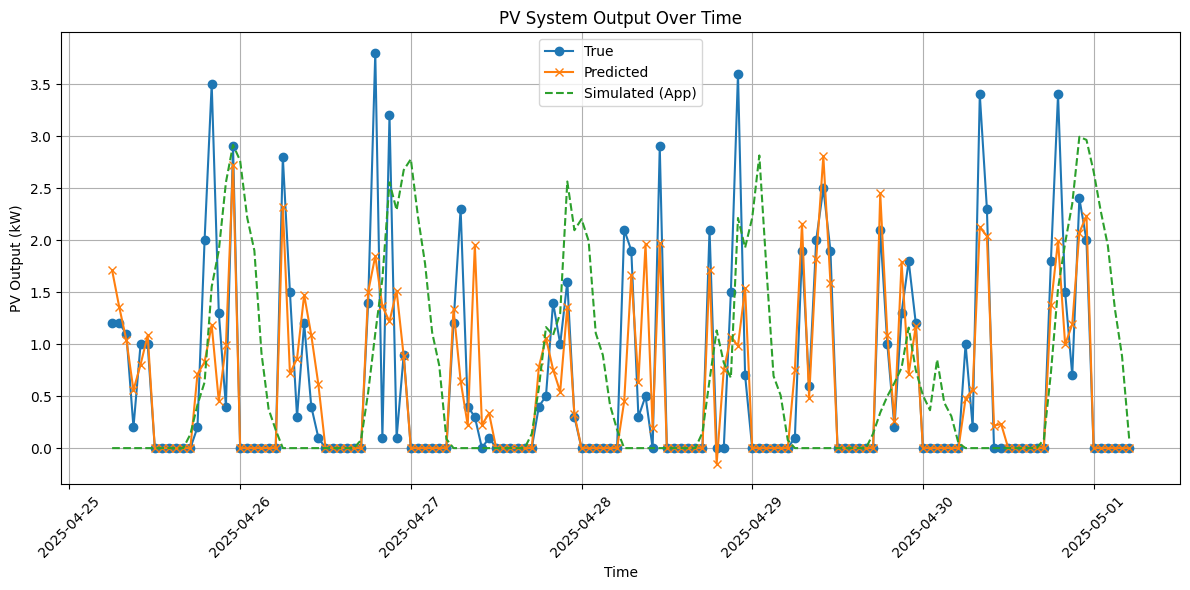

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# --- Reshape and append zeros ---
y_test2 = y_test.reshape(12, -1)
y_pred2 = y_pred.reshape(12, -1)
y_test2 = np.column_stack((y_test2, np.zeros_like(y_test2)))  # Append zeros
y_pred2 = np.column_stack((y_pred2, np.zeros_like(y_pred2)))  # Append zeros
y_test2 = y_test2.flatten()
y_pred2 = y_pred2.flatten()

# --- Load external app data ---
df = pd.read_csv("Result_app.csv")
values = df['Inverter Power Input'].values
energy_production = np.array(values)
energy_production = np.roll(energy_production, 6)  # Shift by 6 hours

# --- Align lengths ---
min_length = min(len(y_test2), len(y_pred2), len(energy_production))
y_test2 = y_test2[:min_length]
y_pred2 = y_pred2[:min_length]
energy_production = energy_production[:min_length]

# --- Create time index (e.g., starting at 6:00 AM) ---
time_index = pd.date_range(start="2025-04-25 06:00:00", periods=min_length, freq='H')


print("For the Linear Regression Model:")
# --- Calculate RMSE ---
RMSE_Pred = np.sqrt(np.mean((y_test2 - y_pred2) ** 2))
print(f"RMSE: {RMSE_Pred:.4f}")
RMSE_App=np.sqrt(np.mean((y_test2 - energy_production) ** 2))
print(f"RMSE_App: {RMSE_App:.4f}")

# --- Plot time series predictions vs actuals ---
plt.figure(figsize=(12, 6))
plt.plot(time_index, y_test2, label='True', marker='o')
plt.plot(time_index, y_pred2, label='Predicted', marker='x')
plt.plot(time_index, energy_production, label='Simulated (App)', linestyle='--')
plt.title('PV System Output Over Time')
plt.xlabel('Time')
plt.ylabel('PV Output (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Training the Neural Network

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import pickle
import os

X_train_NN=np.copy(X_train)
X_test_NN=np.copy(X_test)

# Normalize Features
scaler = StandardScaler()
X_train_NN = scaler.fit_transform(X_train_NN)
X_test_NN = scaler.transform(X_test_NN)

#Building the FFNN Model
model = Sequential([
    Dense(100, activation='relu', input_shape=(X.shape[1],)),
    Dense(64, activation='relu'),
    Dense(100, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(
    X_train_NN, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    verbose=1
)

# Evaluating the Model
y_pred = model.predict(X_test_NN).flatten()
r2 = r2_score(y_test, y_pred)
print(f"\nTest R² Score: {r2:.4f}")

# Saving the Model Weights and Architecture using Pickle
os.makedirs("saved_models", exist_ok=True)

# Saving the model architecture (as a dictionary of layers and activation functions)
model_config = {
    "layers": [layer.get_config() for layer in model.layers],
    "weights": [layer.get_weights() for layer in model.layers]
}

# Save using pickle
with open("saved_models/dnn_model.pkl", "wb") as f:
    pickle.dump(model_config, f)
print("Model saved to 'saved_models/dnn_model.pkl'")

# Saving the Scaler using Pickle 
with open("saved_models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("Scaler saved to 'saved_models/scaler.pkl'")

X_train_NN_quad = np.copy(X_train_quad)
X_test_NN_quad = np.copy(X_test_quad)

# Normalize Features
scaler = StandardScaler()
X_train_NN_quad = scaler.fit_transform(X_train_NN_quad)
X_test_NN_quad = scaler.transform(X_test_NN_quad)

#Building the FFNN Model
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_quad.shape[1],)),
    Dense(64, activation='relu'),
    Dense(100, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

# --- Step 4: Compile ---
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(
    X_train_NN_quad, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    verbose=1
)

# Evaluating the Model
y_pred = model.predict(X_test_NN_quad).flatten()
r2 = r2_score(y_test, y_pred)
print(f"\nTest R² Score: {r2:.4f}")

# Saving the Model Weights and Architecture using Pickle
os.makedirs("saved_models", exist_ok=True)

# Saving the model architecture (as a dictionary of layers and activation functions)
model_config = {
    "layers": [layer.get_config() for layer in model.layers],
    "weights": [layer.get_weights() for layer in model.layers]
}

# Save using pickle
with open("saved_models/dnn_model.pkl", "wb") as f:
    pickle.dump(model_config, f)
print("Model saved to 'saved_models/quad_dnn_model.pkl'")

# Saving the Scaler using Pickle 
with open("saved_models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("Scaler saved to 'saved_models/quad_scaler.pkl'")


Epoch 1/1000


c:\Users\Administrator\miniconda3\envs\torch-cuda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.6496 - val_loss: 1.3047
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8359 - val_loss: 1.0199
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7687 - val_loss: 0.9911
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5455 - val_loss: 0.9753
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5387 - val_loss: 0.8157
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3911 - val_loss: 0.7390
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3751 - val_loss: 0.7196
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3046 - val_loss: 0.7323
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2528 - val_loss: 0.7155
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2767 - val_loss: 0.7274
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2790 - val_loss: 0.7303
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1986 - val_loss: 0.7371


c:\Users\Administrator\miniconda3\envs\torch-cuda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.9606 - val_loss: 0.8763
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5746 - val_loss: 0.8972
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3866 - val_loss: 0.7592
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3254 - val_loss: 0.8726
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3062 - val_loss: 0.6905
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2177 - val_loss: 0.7336
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1958 - val_loss: 0.7228
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1940 - val_loss: 0.7306
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1645 - val_loss: 0.6784
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1361 - val_loss: 0.6684
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1293 - val_loss: 0.7322
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1006 - val_los

# Loading the pre-trained Neural Network

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import pickle
import os

# ----- First model -----
X_train_NN = np.copy(X_train)
X_test_NN = np.copy(X_test)

# Normalize Features
scaler = StandardScaler()
X_train_NN = scaler.fit_transform(X_train_NN)
X_test_NN = scaler.transform(X_test_NN)

# Build the FFNN Model
model = Sequential([
    Dense(100, activation='relu', input_shape=(X.shape[1],)),
    Dense(64, activation='relu'),
    Dense(100, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(
    X_train_NN, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    verbose=1
)

# Evaluate the Model
y_pred = model.predict(X_test_NN).flatten()
r2 = r2_score(y_test, y_pred)
print(f"\nTest R² Score: {r2:.4f}")

# Create save directory
os.makedirs("saved_models", exist_ok=True)

# Save the model using TensorFlow SavedModel format
model.save("saved_models/dnn_model")
print("Model saved to 'saved_models/dnn_model'")

# Save the scaler using pickle
with open("saved_models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("Scaler saved to 'saved_models/scaler.pkl'")

# ----- Second (quadratic) model -----
X_train_NN_quad = np.copy(X_train_quad)
X_test_NN_quad = np.copy(X_test_quad)

# Normalize Features
scaler_quad = StandardScaler()
X_train_NN_quad = scaler_quad.fit_transform(X_train_NN_quad)
X_test_NN_quad = scaler_quad.transform(X_test_NN_quad)

# Build the FFNN Model
model_quad = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_quad.shape[1],)),
    Dense(64, activation='relu'),
    Dense(100, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model_quad.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history_quad = model_quad.fit(
    X_train_NN_quad, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    verbose=1
)

# Evaluate the Model
y_pred_quad = model_quad.predict(X_test_NN_quad).flatten()
r2_quad = r2_score(y_test, y_pred_quad)
print(f"\nTest R² Score (quadratic): {r2_quad:.4f}")

# Save the quadratic model using TensorFlow SavedModel format
model_quad.save("saved_models/quad_dnn_model")
print("Quadratic model saved to 'saved_models/quad_dnn_model'")

# Save the quadratic scaler using pickle
with open("saved_models/quad_scaler.pkl", "wb") as f:
    pickle.dump(scaler_quad, f)
print("Quadratic scaler saved to 'saved_models/quad_scaler.pkl'")


Epoch 1/1000


c:\Users\Administrator\miniconda3\envs\torch-cuda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.2583 - val_loss: 1.3339
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7980 - val_loss: 1.0887
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6863 - val_loss: 1.1113
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5914 - val_loss: 0.8748
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5142 - val_loss: 0.8186
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3949 - val_loss: 0.8163
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3711 - val_loss: 0.7740
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2976 - val_loss: 0.7662
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2476 - val_loss: 0.7436
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2721 - val_loss: 0.7935
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2643 - val_loss: 0.7215
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2323 - val_loss: 0.7

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=saved_models/dnn_model.

In [27]:
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

def load_dnn_model(pickle_path):
    with open(pickle_path, "rb") as f:
        model_config = pickle.load(f)
    
    # Rebuild the model
    model = Sequential()
    for layer_conf in model_config["layers"]:
        layer = Dense.from_config(layer_conf)
        model.add(layer)
    
    # Set weights
    for i, weights in enumerate(model_config["weights"]):
        model.layers[i].set_weights(weights)
    
    return model

def load_scaler(pickle_path):
    with open(pickle_path, "rb") as f:
        scaler = pickle.load(f)
    return scaler

# Load the first (linear) model and scaler
dnn_model = load_dnn_model("saved_models/dnn_model.pkl")
scaler = load_scaler("saved_models/scaler.pkl")

# Load the quadratic model and scaler
quad_dnn_model = load_dnn_model("saved_models/quad_dnn_model.pkl")
quad_scaler = load_scaler("saved_models/quad_scaler.pkl")

# Compile the models before using them for prediction
dnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
quad_dnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Normalize new data using loaded scalers
X_test_NN = scaler.transform(X_test)
X_test_NN_quad = quad_scaler.transform(X_test_quad)

# Predict using loaded models
y_pred_dnn = dnn_model.predict(X_test_NN).flatten()
y_pred_quad_dnn = quad_dnn_model.predict(X_test_NN_quad).flatten()


ValueError: You called `set_weights(weights)` on layer 'dense_15' with a weight list of length 2, but the layer was expecting 0 weights.

In [26]:
import pickle
import tensorflow as tf
from tensorflow.keras.layers import Dense

# Load the model configuration
with open("saved_models/dnn_model.pkl", "rb") as f:
    model_config = pickle.load(f)

# Rebuild the model architecture
model = tf.keras.Sequential()

for layer_config, weights in zip(model_config["layers"], model_config["weights"]):
    # Build each layer based on the stored configuration and load the corresponding weights
    layer = Dense(**layer_config["config"])
    model.add(layer)
    layer.set_weights(weights)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Load the scaler
with open("saved_models/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)



# Load the model configuration
with open("saved_models/quad_dnn_model.pkl", "rb") as f:
    model_config = pickle.load(f)

# Rebuild the model architecture
model = tf.keras.Sequential()

for layer_config, weights in zip(model_config["layers"], model_config["weights"]):
    # Build each layer based on the stored configuration and load the corresponding weights
    layer = Dense(**layer_config["config"])
    model.add(layer)
    layer.set_weights(weights)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Load the scaler
with open("saved_models/quad_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)


# Now you can use the model and scaler as needed


KeyError: 'config'

# Fitting Symbolic Regression

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from pysr import PySRRegressor

# ---- Step 1: Load the saved model ----
model = PySRRegressor()
model.from_file("model.pkl")  # <--- update with your actual saved model file

# ---- Step 2: Predict with the best equation ----
best_fn = model.get_best()
y_pred = best_fn(X_test)

# Convert data to days by appending zeros for night hours
y_test2 = y_test.reshape(12, -1)
y_pred2 = y_pred.reshape(12, -1)
y_test2 = np.column_stack((y_test2, np.zeros_like(y_test2)))  # Append zeros
y_pred2 = np.column_stack((y_pred2, np.zeros_like(y_pred2)))  # Append zeros
y_test2 = y_test2.flatten()
y_pred2 = y_pred2.flatten()
start_time = pd.Timestamp("2025-04-25 00:00:00")
test_time_index = pd.date_range(start=start_time, periods=len(y_test2), freq='H')

# Plot actual vs predicted
plt.figure(figsize=(8, 5))
plt.plot(test_time_index, y_test2, label='Actual', linewidth=2)
plt.plot(test_time_index, y_pred2, label='Predicted (filtered features)', linestyle='--')
plt.xlabel("Time")
plt.ylabel("PV Output")
plt.title("Top Symbolic Regression Model from Hall of Fame")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ---- Step 3: Loop through top 10 equations ----
top_equations = model.equations_.head(10)

for idx, row in top_equations.iterrows():
    eq_str = row["Equation"]
    sympy_fn = row["callable"]  # <-- this gives you a callable function

    try:
        y_pred = sympy_fn(X_test)

        y_test2 = y_test.reshape(12, -1)
        y_pred2 = y_pred.reshape(12, -1)
        y_test2 = np.column_stack((y_test2, np.zeros_like(y_test2)))
        y_pred2 = np.column_stack((y_pred2, np.zeros_like(y_pred2)))
        y_test2 = y_test2.flatten()
        y_pred2 = y_pred2.flatten()
        test_time_index = pd.date_range(start=start_time, periods=len(y_test2), freq='H')

        plt.figure(figsize=(8, 5))
        plt.plot(test_time_index, y_test2, label='Actual', linewidth=2)
        plt.plot(test_time_index, y_pred2,
                 label=f"Pred: {eq_str}\nR² = {r2_score(y_test[:len(y_pred)], y_pred):.3f}",
                 linestyle='--')
        plt.title(f"Equation {idx + 1}")
        plt.xlabel("Time")
        plt.ylabel("Output")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Skipping equation {idx + 1} due to error: {e}")

# ---- Step 4: Final time series plot ----
time_index = pd.date_range(start="2025-04-25", periods=len(y_pred2), freq="H")

plt.figure(figsize=(12, 6))
plt.plot(time_index, y_test2, label='True Values', marker='o')
plt.plot(time_index, y_pred2, label='Predicted Values', marker='x')
# Uncomment the next line only if `energy_production` is defined:
# plt.plot(time_index, energy_production, label='Simulated Values using App', marker='x')
plt.title('True vs Predicted PV Output Over Time')
plt.xlabel('Time')
plt.ylabel('PV Output (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


TypeError: PySRRegressor.from_file() missing 1 required keyword-only argument: 'run_directory'

In [33]:


import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
from pysr import PySRRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load the equations file (Hall of Fame CSV)
hof_df = pd.read_csv("hall_of_fame_2025-04-30_072024.829.csv")  # Adjust the filename if needed
print(hof_df.head())

# Choose the top model (index 0)
eq_str = hof_df.loc[0, "Equation"]
sympy_fn = eval(hof_df.loc[0, "lambda_format"])  # Turn string into Python function

# Apply model to X_test
y_pred = sympy_fn(X_test)
#Converting data to days by appending zeros for the night hours
y_test2 = y_test.reshape(12, -1)
y_pred2 = y_pred.reshape(12, -1)
y_test2 = np.column_stack((y_test2, np.zeros_like(y_test2)))  # Append zeros
y_pred2 = np.column_stack((y_pred2, np.zeros_like(y_pred2)))  # Append zeros
y_test2 = y_test2.flatten()
y_pred2 = y_pred2.flatten()
start_time = pd.Timestamp("2025-04-25 00:00:00")
test_time_index = pd.date_range(start=start_time, periods=len(y_test2), freq='H')

# Plotting the actual vs predicted results
plt.figure(figsize=(8, 5))
plt.plot(test_time_index,y_test2, label='Actual', linewidth=2)
plt.plot(test_time_index,y_pred2, label='Predicted (filtered features)', linestyle='--')
plt.xlabel("Time")
plt.ylabel("PV Output")
plt.title("Top Symbolic Regression Model from Hall of Fame")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# Get the full list of discovered equations
top_equations = model.equations_.head(10)

# Loop through and plot each equation's predictions
for idx, row in top_equations.iterrows():
    eq_str = row["Equation"]
    sympy_fn = row["lambda_format"]  # This is a callable function

    try:
        # Evaluate the model using the symbolic function
        y_pred = sympy_fn(X_test)

        y_test2 = y_test.reshape(12, -1)
        y_pred2 = y_pred.reshape(12, -1)
        y_test2 = np.column_stack((y_test2, np.zeros_like(y_test2)))  # Append zeros
        y_pred2 = np.column_stack((y_pred2, np.zeros_like(y_pred2)))  # Append zeros
        y_test2 = y_test2.flatten()
        y_pred2 = y_pred2.flatten()
        start_time = pd.Timestamp("2025-04-25 00:00:00")
        test_time_index = pd.date_range(start=start_time, periods=len(y_test2), freq='H')

        # Plotting the actual vs predicted results
        plt.figure(figsize=(8, 5))
        plt.plot(test_time_index,y_test2, label='Actual', linewidth=2)
        plt.plot(test_time_index,y_pred2, label=f"Pred: {eq_str}\nR² = {r2_score(y_test[:len(y_pred)], y_pred):.3f}", marker='x')
        plt.title(f"Equation {idx+1}")
        plt.xlabel("Test Sample Index")
        plt.ylabel("Output")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Skipping equation {idx+1} due to error: {e}")

# - Step 3: Create time index for plotting ---
# Assuming we want daily timestamps starting from a specific date
time_index = pd.date_range(start="2025-04-25", periods=len(y_pred2), freq="H")

# --- Step 4: Plotting the predictions and actual values as time series ---
plt.figure(figsize=(12, 6))
plt.plot(time_index, y_test2, label='True Values', marker='o')
plt.plot(time_index, y_pred2, label='Predicted Values', marker='x')
plt.plot(time_index, energy_production, label='Simulated Values using App', marker='x')
plt.title('True vs Predicted PV Output Over Time')
plt.xlabel('Time')
plt.ylabel('PV Output (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


   Complexity       Loss               Equation
0           1  89.481964             0.15277047
1           2  20.446318         exp(2.1354747)
2           3  17.108137         36.612495 * x1
3           4  17.019350    sin(x1) * 37.128925
4           5  15.078956  (x20 - x2) + 22.08736


KeyError: 'lambda_format'

For the Neural Network Model:
RMSE: 0.5110
RMSE_App: 1.3304


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14688\1736898568.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start="2025-04-25 06:00:00", periods=min_length, freq='H')


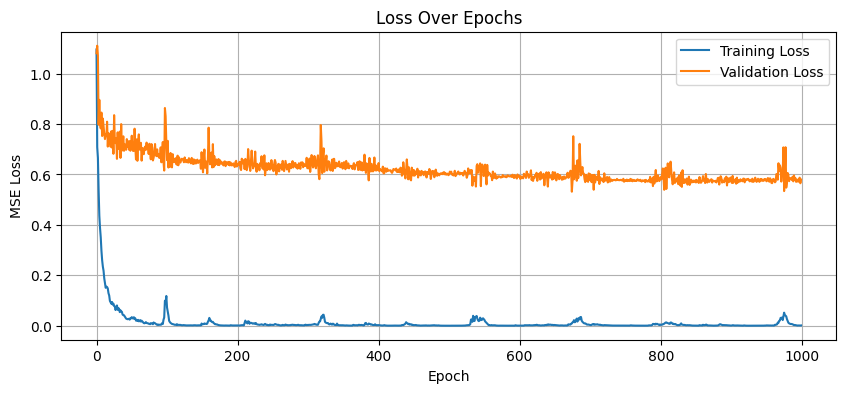

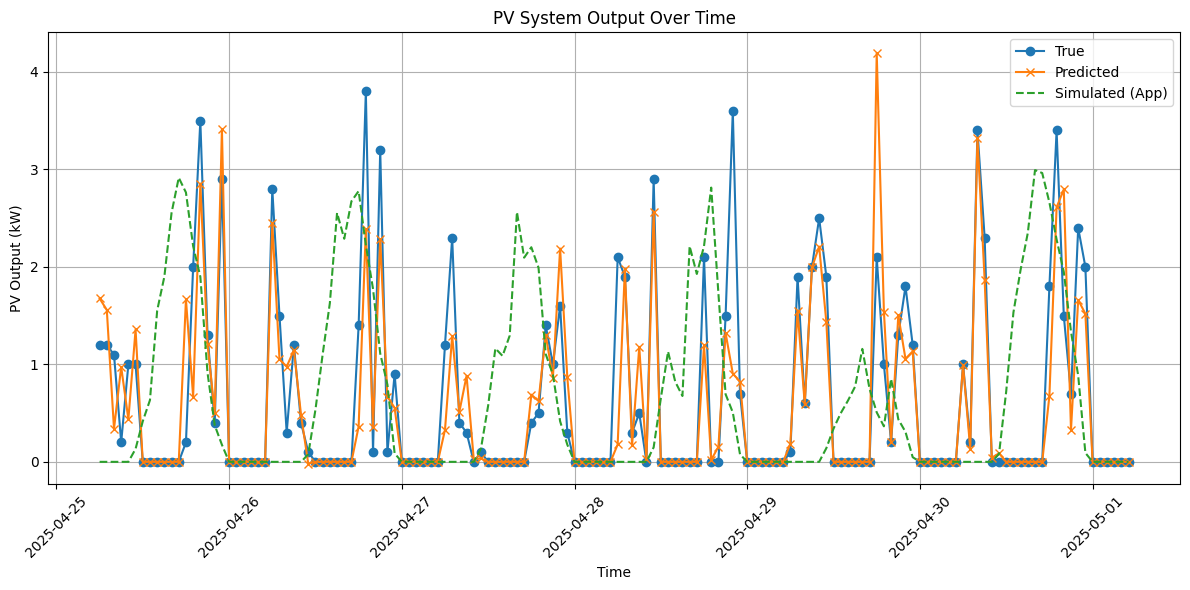

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Reshape and append zeros ---
y_test2 = y_test.reshape(12, -1)
y_pred2 = y_pred.reshape(12, -1)
y_test2 = np.column_stack((y_test2, np.zeros_like(y_test2)))  # Append zeros
y_pred2 = np.column_stack((y_pred2, np.zeros_like(y_pred2)))  # Append zeros
y_test2 = y_test2.flatten()
y_pred2 = y_pred2.flatten()

# --- Load external app data ---
df = pd.read_csv("Result_app.csv")
values = df['Inverter Power Input'].values
energy_production = np.array(values)
energy_production = np.roll(energy_production, 0)  # Shift by 6 hours

# --- Align lengths ---
min_length = min(len(y_test2), len(y_pred2), len(energy_production))
y_test2 = y_test2[:min_length]
print("For the Neural Network Model:")
RMSE_Pred = np.sqrt(np.mean((y_test2 - y_pred2) ** 2))
print(f"RMSE: {RMSE_Pred:.4f}")
RMSE_App=np.sqrt(np.mean((y_test2 - energy_production) ** 2))
print(f"RMSE_App: {RMSE_App:.4f}")
y_pred2 = y_pred2[:min_length]
energy_production = energy_production[:min_length]

# --- Create time index (e.g., starting at 6:00 AM) ---
time_index = pd.date_range(start="2025-04-25 06:00:00", periods=min_length, freq='H')

# --- Plot loss curves ---
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot time series predictions vs actuals ---
plt.figure(figsize=(12, 6))
plt.plot(time_index, y_test2, label='True', marker='o')
plt.plot(time_index, y_pred2, label='Predicted', marker='x')
plt.plot(time_index, energy_production, label='Simulated (App)', linestyle='--')
plt.title('PV System Output Over Time')
plt.xlabel('Time')
plt.ylabel('PV Output (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Predicting the average daily energy for the whole data based purely on the weather data

In [ ]:
import pandas as pd
import numpy as np





# Load Data
df_weather = pd.read_csv('Weather_Data.csv')
df_PV_Out = pd.read_excel('Solar.xlsx')

# Clean column names
df_weather.columns = df_weather.columns.str.strip()
df_PV_Out.columns = df_PV_Out.columns.str.strip()

# Convert dates
df_PV_Out['Date'] = pd.to_datetime(df_PV_Out['Date']).dt.date
df_weather['period_end'] = pd.to_datetime(df_weather['period_end'])
df_weather['Date'] = df_weather['period_end'].dt.date

# Filter weather by hour
df_weather = df_weather[df_weather['period_end'].dt.hour.between(6, 17)]

# Match common dates
common_dates = set(df_PV_Out['Date']).intersection(set(df_weather['Date']))
df_weather_filtered = df_weather[df_weather['Date'].isin(common_dates)].drop(columns=['period_end'])
df_PV_filtered = df_PV_Out[df_PV_Out['Date'].isin(common_dates)]

# Sort for alignment
df_weather_filtered = df_weather_filtered.sort_values('Date')
df_PV_filtered = df_PV_filtered.sort_values('Date')

# Drop Date AFTER filtering
df_weather_filtered = df_weather_filtered.drop(columns=['Date'])
df_PV_filtered = df_PV_filtered.drop(columns=['Date'])

pre = Preprocess(latitude=34.2599, longitude=-35.8419)
D=int(len(df_weather_filtered)/12)
irradiation=np.zeros((D,12))
for day in range(0, D, 1):
    for time in range(0, 12, 1):
        irradiation[day,time]=pre.estimate_solar_irradiation(day, time+6, tilt_deg=30, azimuth_deg=230)
irradiation=irradiation.flatten()



# Convert to NumPy
X = df_weather_filtered.to_numpy()
y = df_PV_filtered.to_numpy()

X = np.column_stack((X, irradiation))
# Display or process the filtered DataFrame
y=df_PV_filtered.to_numpy()

y_pred = model.predict(X)
y_pred = y_pred.reshape(12,-1)
irradiation2=irradiation.reshape(12,-1)
irradiation2=np.average(irradiation2,axis=0)
y_pred=np.average(y_pred,axis=0)

35/35 [==============================] - 0s 2ms/step


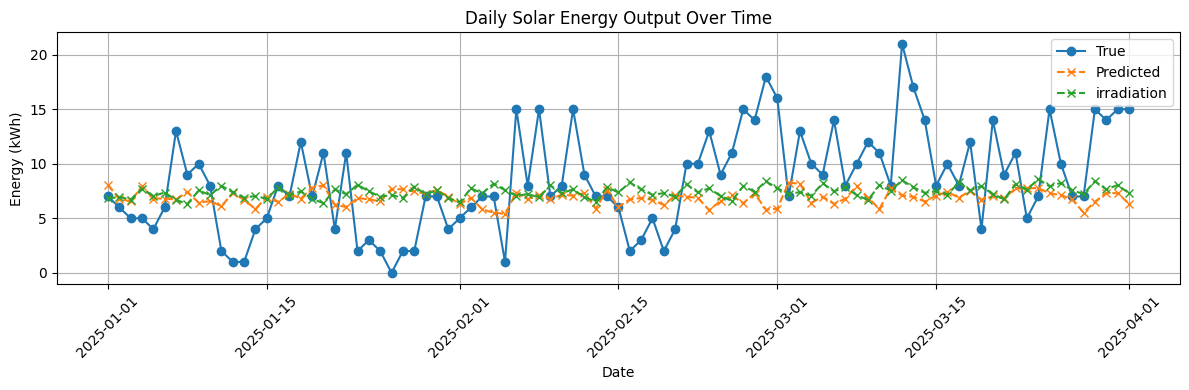

In [ ]:
import matplotlib.pyplot as plt

# Assuming df_PV_filtered still has the original Date column before you dropped it
df_temp = df_PV_Out[df_PV_Out['Date'].isin(common_dates)].sort_values('Date')

plt.figure(figsize=(12, 4))
plt.plot(df_temp['Date'], df_temp['Energy'], marker='o',label='True')  # Original data
plt.plot(df_temp['Date'], y_pred/45, marker='x', linestyle='--',label='Predicted')        
plt.plot(df_temp['Date'], irradiation2/45, marker='x', linestyle='--',label='irradiation')           

plt.legend()
plt.title('Daily Solar Energy Output Over Time')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Fitting Symbolic Regression

c:\Users\Administrator\miniconda3\envs\torch-cuda\Lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.050e+05
Progress: 1761 / 3100 total iterations (56.806%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           9.554e-01  1.594e+01  y = 1.0493
3           8.961e-01  3.203e-02  y = x₀ * 0.070713
4           7.313e-01  2.033e-01  y = exp(x₂ / 277.82)
5           7.310e-01  3.211e-04  y = exp(sin(x₂ / 266.5))
6           6.396e-01  1.336e-01  y = exp((x₅ / 7.916) / x₂)
7           6.222e-01  2.761e-02  y = exp(sqrt(x₅ / 0.09923) / x₂)
8           5.648e-01  9.685e-02  y = sin((x₂ / 56.034) + -1.0561) * 1.8195
9           5.453e-01  3.514e-02  y = exp(sin((x₂ / 56.751) + -0.98202)) + -0.76224
13          5.246e-01  9.642e-03  y = exp(((sin((x₂ / 54.749) + -0.95688) - x₁) - x₁) * 2.05...
                                      48)
15          5.209e-01  3.

[ Info: Final population:
[ Info: Results saved to:
C:\Users\Administrator\AppData\Local\Temp\ipykernel_25872\848951831.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start=start_time, periods=length, freq='H')


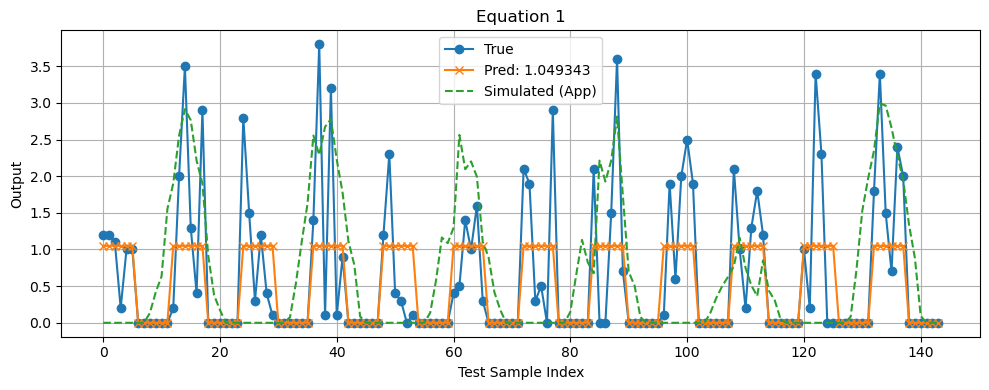

Saved model for equation 2 to 'saved_models/model_eq_2.pkl'
The RMSE for equation 2: 0.7767


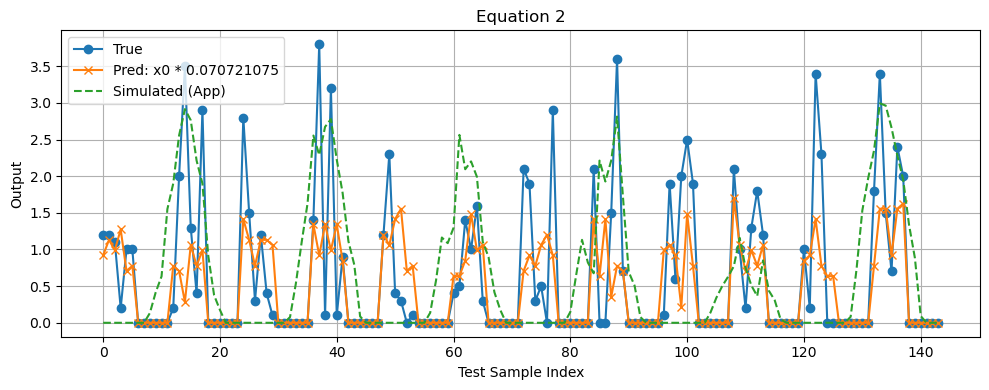

Saved model for equation 3 to 'saved_models/model_eq_3.pkl'
The RMSE for equation 3: 0.6479


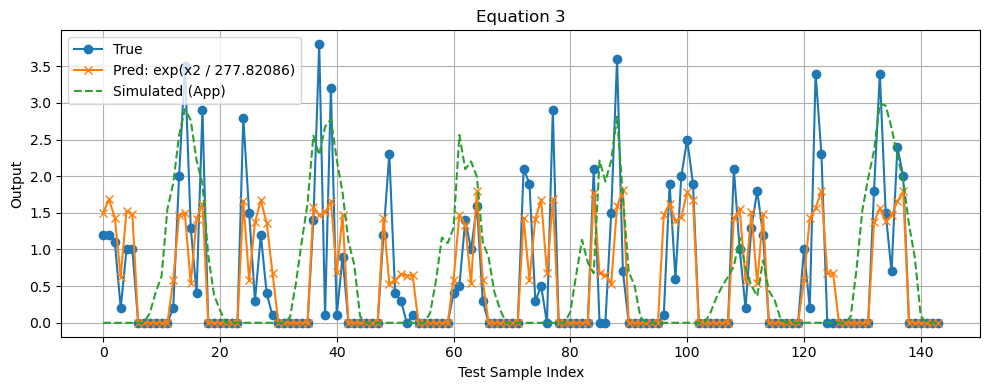

Saved model for equation 4 to 'saved_models/model_eq_4.pkl'
The RMSE for equation 4: 0.6203


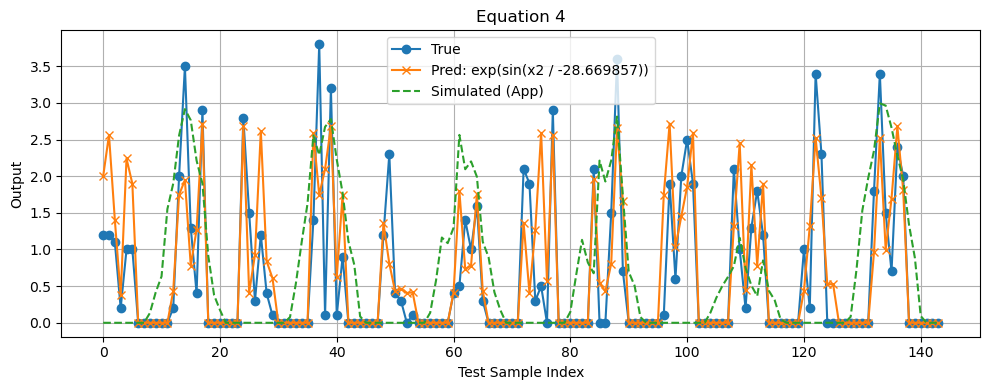

Saved model for equation 5 to 'saved_models/model_eq_5.pkl'
The RMSE for equation 5: 0.5993


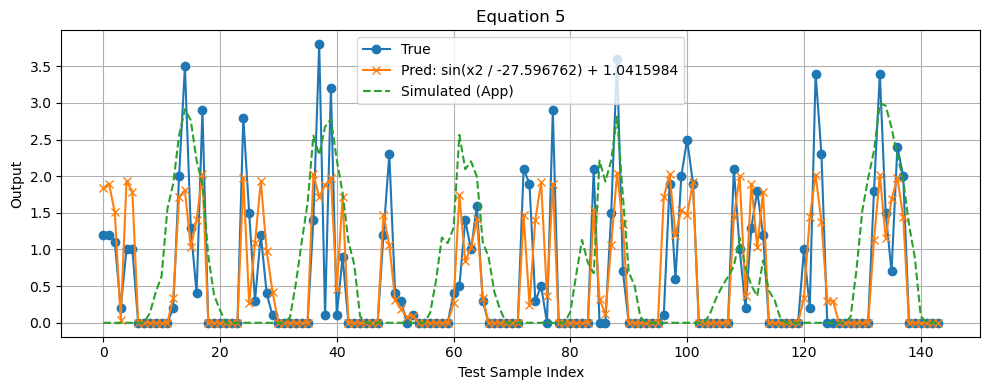

Saved model for equation 6 to 'saved_models/model_eq_6.pkl'
The RMSE for equation 6: 0.6025


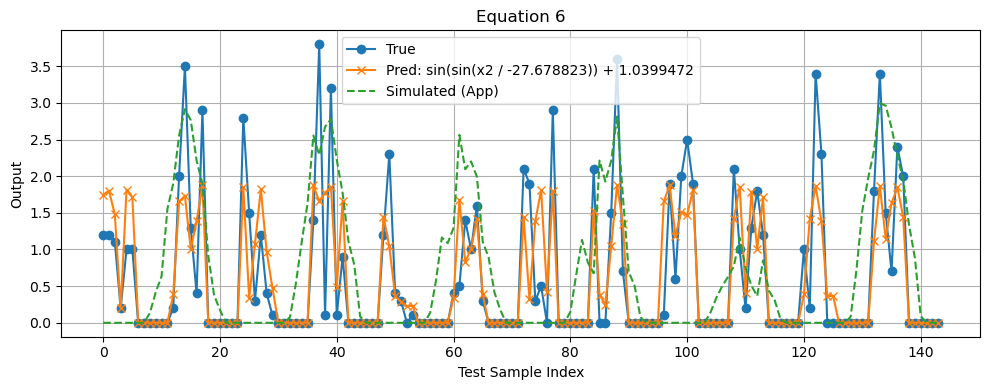

Saved model for equation 7 to 'saved_models/model_eq_7.pkl'
The RMSE for equation 7: 0.5632


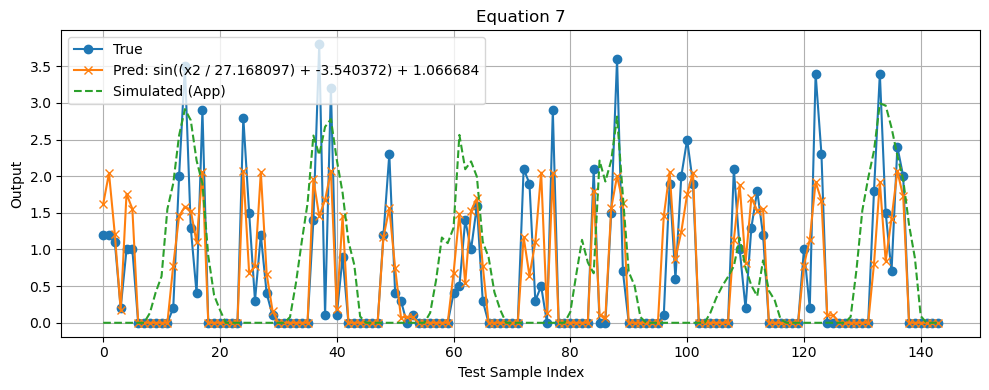

Saved model for equation 8 to 'saved_models/model_eq_8.pkl'
The RMSE for equation 8: 0.5697


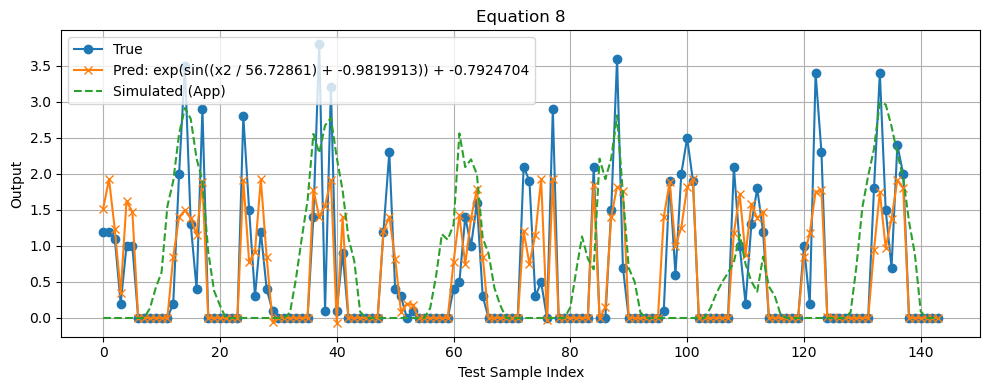

Saved model for equation 9 to 'saved_models/model_eq_9.pkl'
The RMSE for equation 9: 0.5691


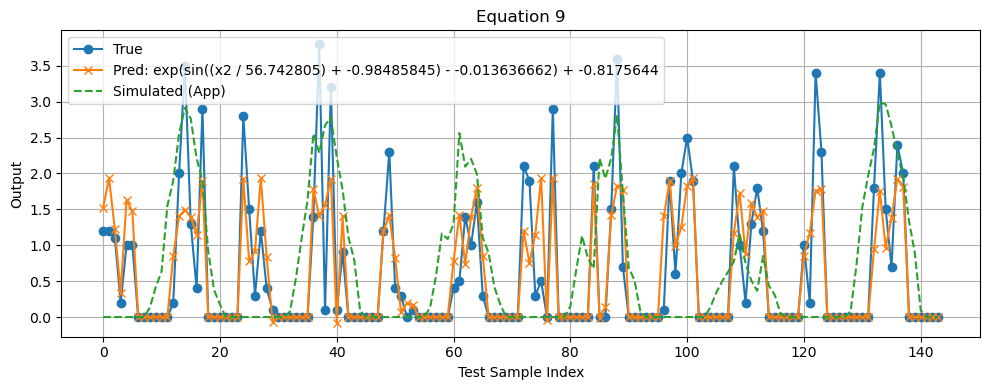

Saved model for equation 10 to 'saved_models/model_eq_10.pkl'
The RMSE for equation 10: 0.5382


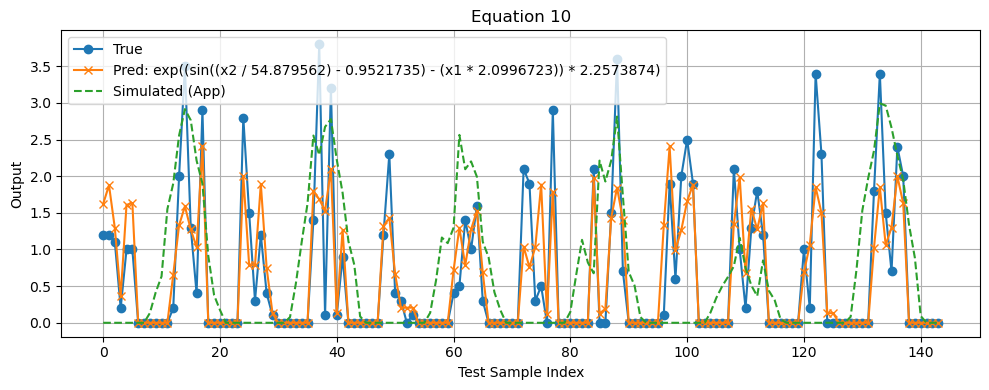

In [42]:
from sklearn.model_selection import train_test_split
from pysr import PySRRegressor

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model on training set
model = PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["sqrt", "log", "exp", "sin", "cos"],
    model_selection="best",  # <<<< ADD THIS LINE
    verbosity=1,
)

model.fit(X_train, y_train)


import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pickle
import os

# Load the CSV file into a DataFrame
df = pd.read_csv("Result_app.csv")
# Display the first few rows of the DataFrame
print(df.head())
# Extract the 'value' column
values = df['Inverter Power Input'].values
length = len(values)
# Example: replace this with your actual data
energy_production = np.array(values)  # 120 hourly values
energy_production = np.roll(energy_production, 3)  # Shift by 6 hours
# Create a datetime index starting from a given date
start_time = pd.Timestamp("2025-04-25 00:00:00")
time_index = pd.date_range(start=start_time, periods=length, freq='H')

# Create a pandas Series for plotting
energy_series = pd.Series(energy_production, index=time_index)

# Create a directory to save the pickled models
os.makedirs("saved_models", exist_ok=True)

# Get the full list of discovered equations
top_equations = model.equations_.head(10)

# Loop through and plot each equation's predictions
for idx, row in top_equations.iterrows():
    eq_str = row["equation"]
    sympy_fn = row["lambda_format"]  # This is a callable function

    try:
        # Evaluate the model using the symbolic function
        y_pred = sympy_fn(X_test)

        # Save the callable model to a pickle file
        filename = f"saved_models/model_eq_{idx+1}.pkl"
        with open(filename, 'wb') as f:
            pickle.dump(sympy_fn, f)

        print(f"Saved model for equation {idx+1} to '{filename}'")

        # Plot true vs predicted
        plt.figure(figsize=(10, 4))
        y_test2=y_test.reshape(12,-1)
        y_pred2=y_pred.reshape(12,-1)
        y_test2=np.column_stack((y_test2, np.zeros_like(y_test2))) 
        y_pred2=np.column_stack((y_pred2, np.zeros_like(y_pred2)))
        y_test2 = y_test2.flatten()
        y_pred2 = y_pred2.flatten()

        RMSE_Pred = np.sqrt(np.mean((y_test2 - y_pred2) ** 2))
        print(f"The RMSE for equation {idx+1}: {RMSE_Pred:.4f}")

        plt.plot(y_test2, label="True", marker='o')
        plt.plot(y_pred2, label=f"Pred: {eq_str}", marker='x')
        plt.plot(energy_production, label='Simulated (App)', linestyle='--')
        plt.title(f"Equation {idx+1}")
        plt.xlabel("Test Sample Index")
        plt.ylabel("Output")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Skipping equation {idx+1} due to error: {e}")

# Evaluate on test set
y_pred = model.predict(X_test)




In [43]:
import re

def count_features(equation_str):
    # Find all x0, x1, ..., xN in the string
    return len(set(re.findall(r'x\d+', equation_str)))

# Add a column with the number of features used
model.equations_["n_features"] = model.equations_["equation"].apply(count_features)

# Find the equation with the most features
most_features_row = model.equations_.loc[model.equations_["n_features"].idxmax()]

# Display it
print("Equation with most features:")
print(most_features_row[["equation", "n_features", "complexity", "score"]])


Equation with most features:
equation      sqrt(sqrt(exp(((sin((x2 / 55.714787) + -0.9611...
n_features                                                    5
complexity                                                   26
score                                                  0.002362
Name: 18, dtype: object


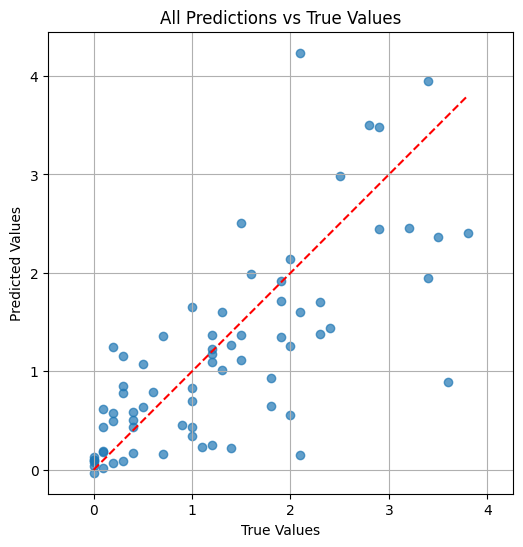

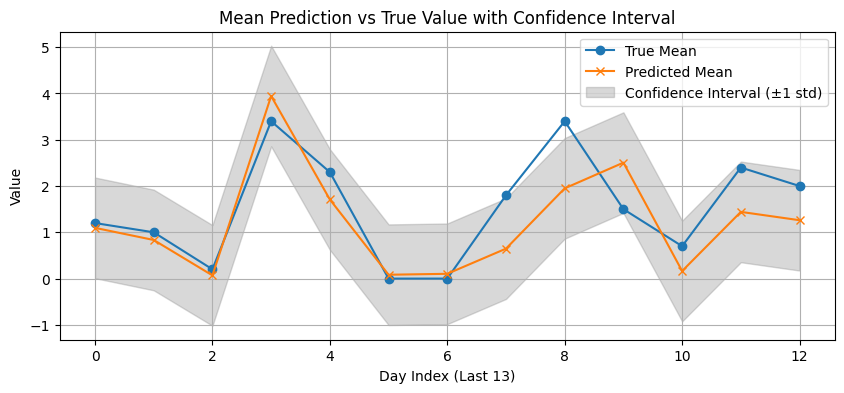

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Scattering the predicted values against the true values to see if linear relationship exists
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45° line
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('All Predictions vs True Values')
plt.grid(True)
plt.axis('equal')
plt.show()

# Compute Mean & Std Over Last 13 Days 
# Ensure these are NumPy arrays
y_test = np.asarray(y_test)
y_pred = np.asarray(y_pred)

# Select last 13 entries
y_true_last13 = y_test[-13:]
y_pred_last13 = y_pred[-13:]

# Average per day (assuming 1 value per day, this just shows the mean and std as constant)
y_true_mean = y_true_last13
y_pred_mean = y_pred_last13
y_pred_std = np.full_like(y_pred_mean, np.std(y_pred_last13))  # same std for simplicity

# --- Step 3: Plot Mean and Confidence Interval ---
days = np.arange(len(y_pred_mean))

plt.figure(figsize=(10, 4))
plt.plot(days, y_true_mean, label='True Mean', marker='o')
plt.plot(days, y_pred_mean, label='Predicted Mean', marker='x')

# Confidence interval (±1 std dev)
plt.fill_between(days,
                 y_pred_mean - y_pred_std,
                 y_pred_mean + y_pred_std,
                 color='gray', alpha=0.3, label='Confidence Interval (±1 std)')

plt.xlabel('Day Index (Last 13)')
plt.ylabel('Value')
plt.title('Mean Prediction vs True Value with Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pysindy as ps

# X is the time series (states), y is dx/dt (derivatives)
# what we hope to do is to find the derivatives of the time series
# and then use SINDy to find the governing equations
# though the derivates were not useful so we sticked to the original time series and the other models
optimizer = ps.STLSQ(threshold=0.5,alpha=0.1, fit_intercept=True)
differentiation_method = ps.FiniteDifference()
X_fused_train = np.column_stack((X_train, y_train))  # Combine features and target for training
X_fused_test = np.column_stack((X_test, y_test))  # Combine features and target for testing
model_sindy = ps.SINDy(optimizer=optimizer, differentiation_method=differentiation_method)
model_sindy.fit(X_fused_train, t=1.0)  # t is time step

model_sindy.print()
y_pred_sindy = model_sindy.predict(X_fused_test)



C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(


(x0)' = 0.024
(x1)' = 0.000
(x2)' = 75.547 x0 + 3.405 x2 + 2.925 x4 + 24.382 x5 + -21.806 x6 + -12.605 x7 + 3.885 x9 + -4.996 x10 + -41.601 x11 + 35.610 x12 + 316.813 x13 + -23.271 x15 + 0.737 x21 + -2.702 x25 + -1.700 x0^2 + 63.816 x0 x1 + -9.720 x0 x13 + 224.871 x0 x14 + -0.636 x0 x15 + -246.934 x0 x17 + 1833.353 x0 x18 + -40.057 x0 x23 + 88.534 x0 x24 + 2.905 x0 x38 + -10.198 x1 x2 + -9.543 x1 x4 + -64.257 x1 x5 + 57.829 x1 x6 + 35.421 x1 x7 + -106.413 x1 x8 + -11.196 x1 x9 + 15.695 x1 x10 + 121.412 x1 x11 + -103.918 x1 x12 + -25.103 x1 x13 + 92.432 x1 x15 + -6.921 x1 x16 + -1.857 x1 x22 + -793.692 x1 x23 + 32.295 x1 x25 + 0.424 x2 x17 + -2.780 x2 x18 + -1.361 x2 x20 + 4.752 x3 x14 + -30.287 x3 x17 + 229.799 x3 x18 + 3.268 x3 x23 + -4.564 x3 x24 + 3.005 x4 x14 + 3.400 x4 x17 + -25.819 x4 x18 + 23.136 x5 x14 + 29.518 x5 x17 + -236.536 x5 x18 + -11.258 x5 x23 + 12.988 x5 x24 + -2.966 x5 x38 + -9.252 x6 x14 + -19.980 x6 x17 + 160.116 x6 x18 + -1.011 x6 x20 + 8.307 x6 x23 + -9.625 x6 x2

# Trying to understand the weather data

Dataset preview:
   air_temp  albedo  azimuth  clearsky_dhi  clearsky_dni  clearsky_ghi  \
0         2    0.17      -75             0             0             0   
1         2    0.17      -86             0             0             0   
2         2    0.17      -94             0             0             0   
3         2    0.17     -102             0             0             0   
4         2    0.17     -110             4            45             8   

   clearsky_gti  cloud_opacity  dewpoint_temp  dhi  ...  snow_depth  \
0             0           31.6           -0.8    0  ...        12.2   
1             0           10.4           -0.8    0  ...        12.2   
2             0            4.8           -1.0    0  ...        12.2   
3             0            0.4           -1.1    0  ...        12.2   
4            18            2.7           -0.9    5  ...        12.2   

   snow_water_equivalent  snow_soiling_rooftop  snow_soiling_ground  \
0                    1.6                

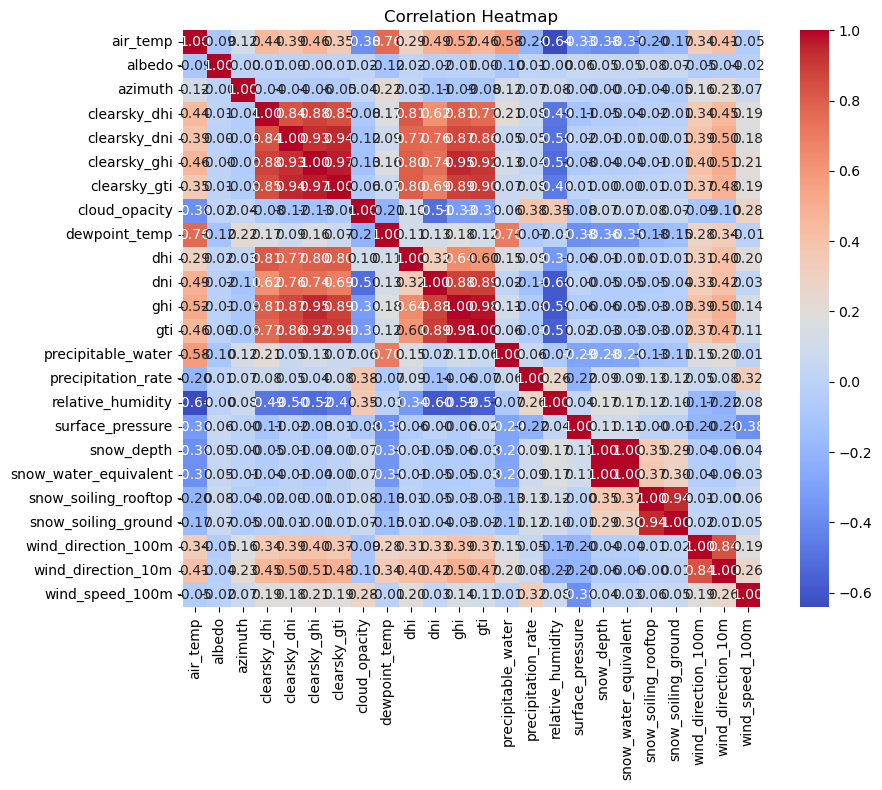

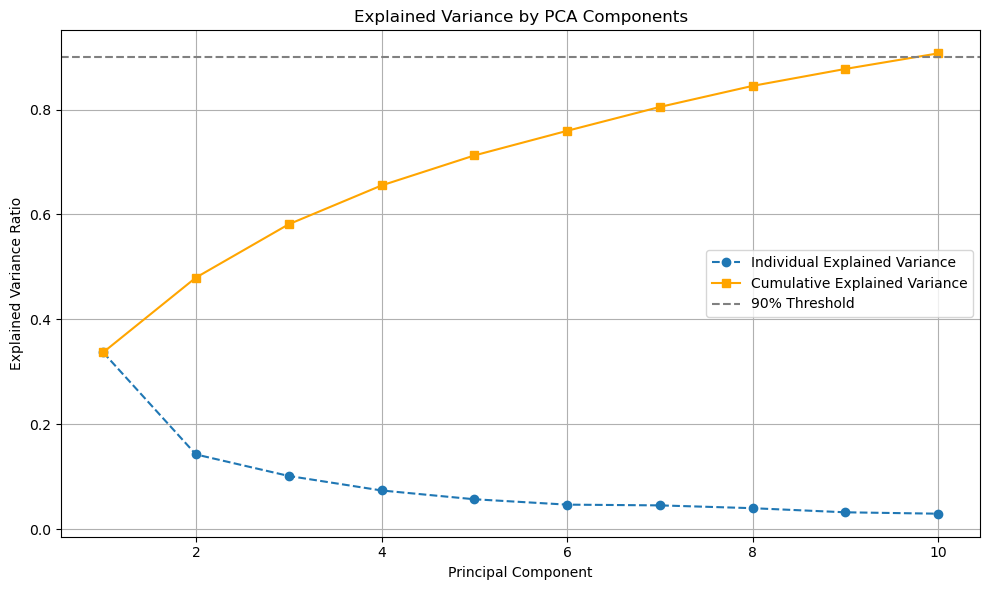


Original shape (after column removal): (36504, 24)
Reduced shape with 90% variance preserved: (36504, 10)

PCA Result Preview:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.429894  2.559064 -1.135147 -0.434183 -1.002864  1.243136 -0.074241   
1 -3.328460  2.465435 -1.450615 -0.108794 -1.072520  1.219940 -0.365905   
2 -3.290170  2.436437 -1.554848 -0.016649 -1.067443  1.228297 -0.449535   
3 -3.242357  2.425981 -1.640423  0.047559 -1.078809  1.203243 -0.526230   
4 -3.117268  2.502081 -1.617359 -0.067131 -1.023600  1.212566 -0.534404   

        PC8       PC9      PC10  
0 -0.210895 -0.522162 -0.014119  
1 -0.117584 -0.452432  0.248043  
2 -0.094519 -0.482662  0.299974  
3 -0.083905 -0.507083  0.324537  
4 -0.104996 -0.514234  0.296347  


c:\Users\Administrator\miniconda3\envs\torch-cuda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


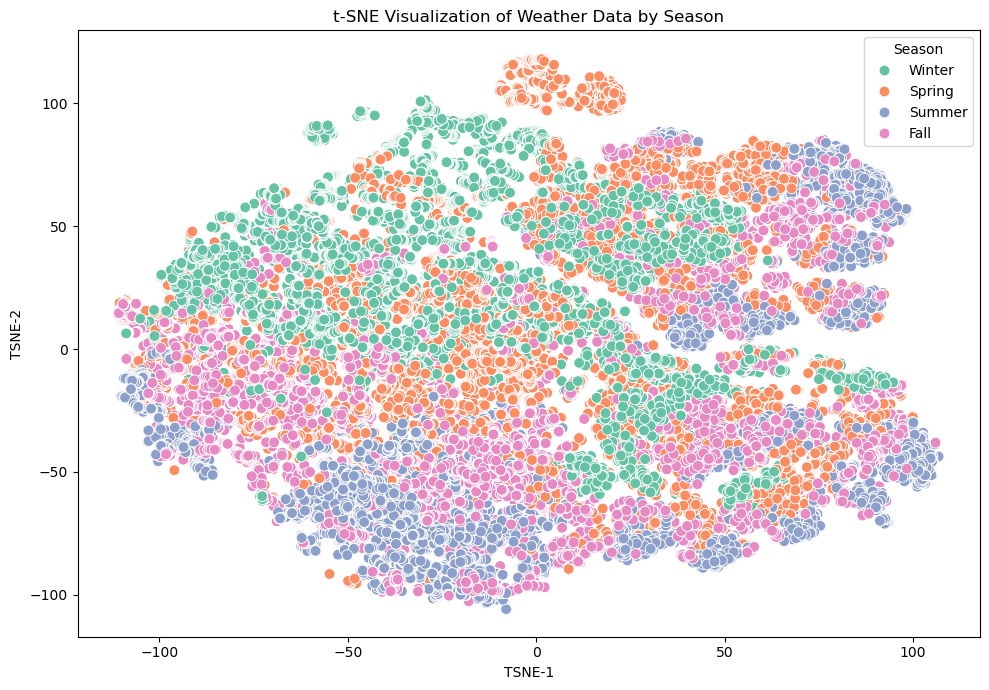

PCA and scaler saved to pca_transform.pkl


In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
from sklearn.manifold import TSNE

# Load the dataset
data = pd.read_csv("Weather_Data.csv")

# Display the first few rows (optional)
print("Dataset preview:")
print(data.head())

# Drop non-numeric columns (if any)
numeric_data = data.select_dtypes(include=['number'])

# --- Extract season labels from 'period_end' ---
if 'period_end' in data.columns:
    data['period_end'] = pd.to_datetime(data['period_end'])
    month = data['period_end'].dt.month
else:
    raise ValueError("No 'period_end' column found in dataset.")

# Map months to seasons
def get_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data['Season'] = month.apply(get_season)

# --- Prepare numeric data ---
numeric_data = data.select_dtypes(include=['number'])

# Remove the last two columns
if numeric_data.shape[1] > 2:
    numeric_data = numeric_data.iloc[:, :-2]
else:
    raise ValueError("Not enough numeric columns to remove the last two.")

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Standardize the numeric data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Apply PCA to preserve 90% of the variance
pca = PCA(n_components=0.90)
principal_components = pca.fit_transform(scaled_data)

# Plot explained variance and cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance,
         marker='o', linestyle='--', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
         marker='s', linestyle='-', label='Cumulative Explained Variance', color='orange')
plt.axhline(y=0.90, color='gray', linestyle='--', label='90% Threshold')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the shape of the PCA result
print(f"\nOriginal shape (after column removal): {scaled_data.shape}")
print(f"Reduced shape with 90% variance preserved: {principal_components.shape}")

# Create a DataFrame for the PCA result (optional)
pca_df = pd.DataFrame(principal_components, columns=[f"PC{i+1}" for i in range(principal_components.shape[1])])
print("\nPCA Result Preview:")
print(pca_df.head())

# --- t-SNE dimensionality reduction ---
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(scaled_data)

# Combine t-SNE results with season labels
tsne_df = pd.DataFrame(tsne_result, columns=['TSNE-1', 'TSNE-2'])
tsne_df['Season'] = data['Season']

# --- Plot t-SNE ---
plt.figure(figsize=(10, 7))
sns.scatterplot(data=tsne_df, x='TSNE-1', y='TSNE-2', hue='Season', palette='Set2', s=60)
plt.title("t-SNE Visualization of Weather Data by Season")
plt.legend(title='Season')
plt.tight_layout()
plt.show()


# Save scaler and PCA to a pickle file
with open("pca_transform.pkl", "wb") as f:
    pickle.dump({'scaler': scaler, 'pca': pca}, f)

print("PCA and scaler saved to pca_transform.pkl")


Dataset preview:
   air_temp  albedo  azimuth  clearsky_dhi  clearsky_dni  clearsky_ghi  \
0         2    0.17      -75             0             0             0   
1         2    0.17      -86             0             0             0   
2         2    0.17      -94             0             0             0   
3         2    0.17     -102             0             0             0   
4         2    0.17     -110             4            45             8   

   clearsky_gti  cloud_opacity  dewpoint_temp  dhi  ...  snow_depth  \
0             0           31.6           -0.8    0  ...        12.2   
1             0           10.4           -0.8    0  ...        12.2   
2             0            4.8           -1.0    0  ...        12.2   
3             0            0.4           -1.1    0  ...        12.2   
4            18            2.7           -0.9    5  ...        12.2   

   snow_water_equivalent  snow_soiling_rooftop  snow_soiling_ground  \
0                    1.6                

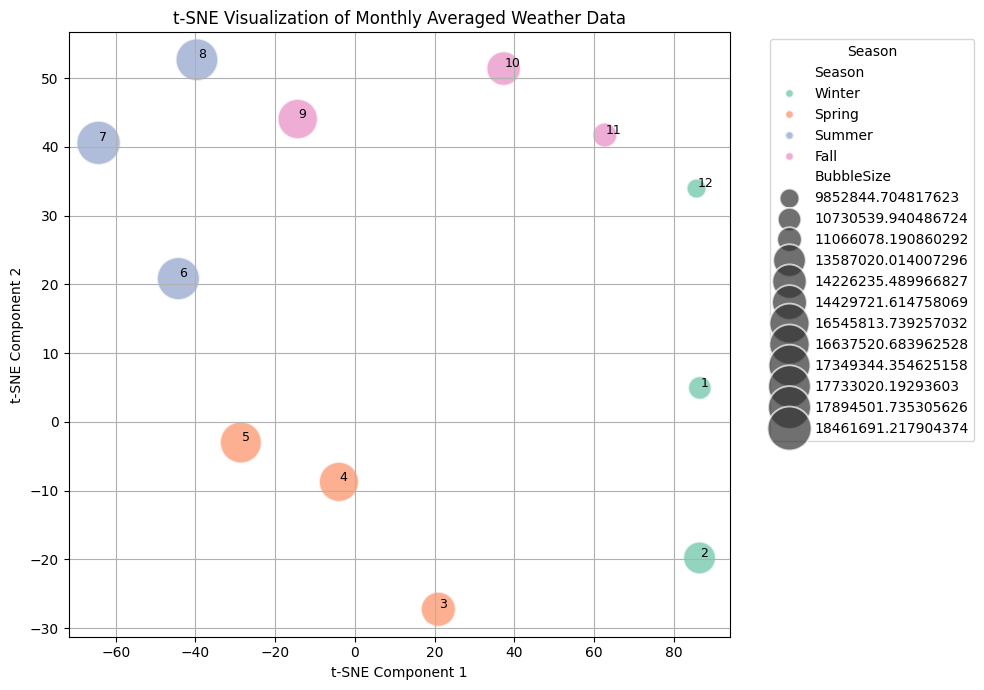

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Load the dataset
data = pd.read_csv("Weather_Data.csv")

print("Dataset preview:")
print(data.head())

# Ensure period_end is datetime and assign Month (overwrite safely)
if 'period_end' in data.columns:
    data['period_end'] = pd.to_datetime(data['period_end'])
    data['Month'] = data['period_end'].dt.month
else:
    raise ValueError("No 'period_end' column found in dataset.")

# Select numeric columns (but keep 'Month')
numeric_cols = data.select_dtypes(include=['number']).columns.tolist()
if 'Month' not in numeric_cols:
    numeric_cols.append('Month')

numeric_data = data[numeric_cols]

# Group by Month and calculate mean and variance
monthly_avg = numeric_data.groupby('Month').mean().reset_index()
monthly_var = numeric_data.groupby('Month').var().mean(axis=1).reset_index(name='Variance')

# Merge variance into monthly_avg
monthly_avg = pd.merge(monthly_avg, monthly_var, on='Month')

# Map months to seasons
def get_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

monthly_avg['Season'] = monthly_avg['Month'].apply(get_season)

# Scale numeric features (exclude Month, Season, Variance)
features = monthly_avg.drop(columns=['Month', 'Season', 'Variance'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(scaled_data)

# Create DataFrame for plotting
tsne_df = pd.DataFrame(tsne_result, columns=['TSNE-1', 'TSNE-2'])
tsne_df['Season'] = monthly_avg['Season']
tsne_df['Month'] = monthly_avg['Month']
tsne_df['Variance'] = monthly_avg['Variance']

# Scale variance for bubble size (optional tuning factor)
size_scale = 500
tsne_df['BubbleSize'] = tsne_df['Variance'] * size_scale

# Plot t-SNE with bubble size and month labels
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=tsne_df,
    x='TSNE-1',
    y='TSNE-2',
    hue='Season',
    size='BubbleSize',
    sizes=(200, 1000),  # min and max bubble sizes
    palette='Set2',
    legend='full',
    alpha=0.7
)

# Add month labels on top of bubbles
for i in range(len(tsne_df)):
    plt.text(
        tsne_df.loc[i, 'TSNE-1'] + 0.2,
        tsne_df.loc[i, 'TSNE-2'] + 0.2,
        str(tsne_df.loc[i, 'Month']),
        fontsize=9
    )

plt.title("t-SNE Visualization of Monthly Averaged Weather Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.legend(title='Season', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [3]:
import pickle

# Load the scaler and PCA from pickle
with open("pca_transform.pkl", "rb") as f:
    loaded_objects = pickle.load(f)

loaded_scaler = loaded_objects['scaler']
loaded_pca = loaded_objects['pca']

# Example: Transform new data
new_data = pd.read_csv("Weather_Data.csv")
new_numeric = new_data.select_dtypes(include=['number']).iloc[:, :-2]  # Remove last 2 columns

# Apply the same transformation
new_scaled = loaded_scaler.transform(new_numeric)
new_pca_result = loaded_pca.transform(new_scaled)

# Create DataFrame (optional)
new_pca_df = pd.DataFrame(new_pca_result, columns=[f"PC{i+1}" for i in range(new_pca_result.shape[1])])
print("\nTransformed new data preview:")
print(new_pca_df.head())



Transformed new data preview:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.429894  2.559064 -1.135147 -0.434183 -1.002864  1.243136 -0.074241   
1 -3.328460  2.465435 -1.450615 -0.108794 -1.072520  1.219940 -0.365905   
2 -3.290170  2.436437 -1.554848 -0.016649 -1.067443  1.228297 -0.449535   
3 -3.242357  2.425981 -1.640423  0.047559 -1.078809  1.203243 -0.526230   
4 -3.117268  2.502081 -1.617359 -0.067131 -1.023600  1.212566 -0.534404   

        PC8       PC9      PC10  
0 -0.210895 -0.522162 -0.014119  
1 -0.117584 -0.452432  0.248043  
2 -0.094519 -0.482662  0.299974  
3 -0.083905 -0.507083  0.324537  
4 -0.104996 -0.514234  0.296347  


# Fitting LR on the new PCA features

Selected Features (mask): [False False  True  True  True False False  True  True  True False  True]
Refit model saved to 'saved_models/linear_model_filtered_with_PCA.pkl'

Selected Features and Coefficients:
Feature x0: Coefficient = 0.14106055400177353
Feature x0: Coefficient = 0.1554918681040342
Feature x0: Coefficient = 0.1135033437070151
Feature x0: Coefficient = -0.14371377672636582
Feature x0: Coefficient = 0.47613379557319924
Feature x0: Coefficient = 0.14051454516686773
Feature x0: Coefficient = -0.20870178550950905

Regression Equation:
y = 0.141*x0 + 0.155*x0 + 0.114*x0 + -0.144*x0 + 0.476*x0 + 0.141*x0 + -0.209*x0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10732\3928793017.py:81: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test_time_index = pd.date_range(start=start_time, periods=len(y_test2), freq='H')


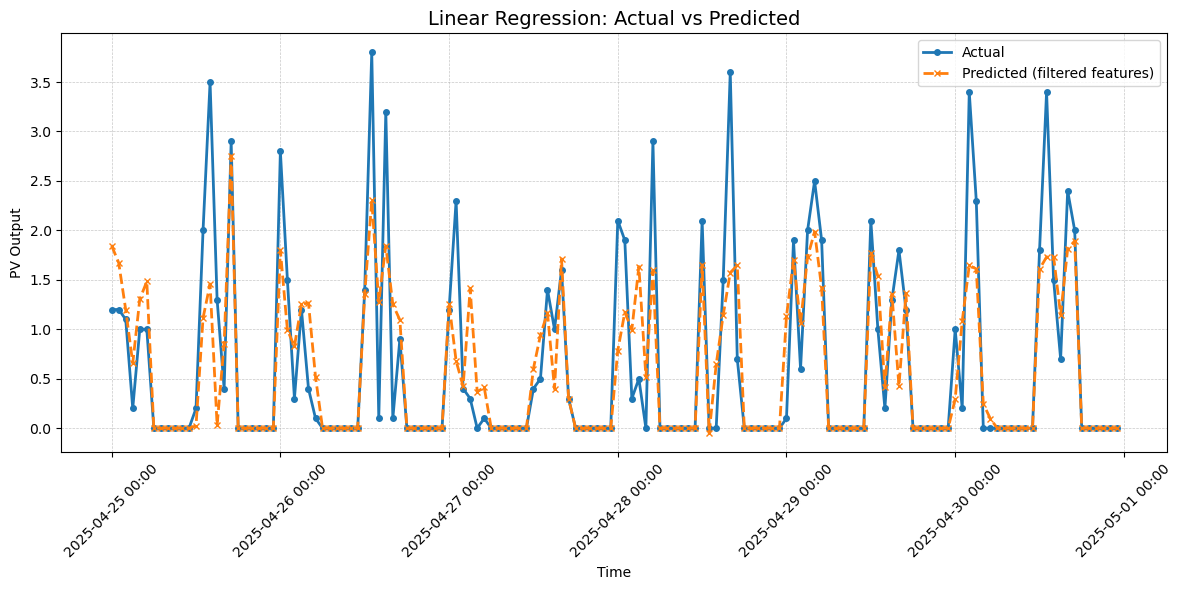

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

X = np.column_stack((filtered_df_weather.to_numpy(), irradiation2))
# Display or process the filtered DataFrame
y=df_PV_Out.to_numpy()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # keep 95% of variance
X_pca = pca.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42,shuffle=True)


# Fitting the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Masking features based on coefficients
coef_mask = np.abs(lr.coef_) > 1e-1
coef_mask2 = coef_mask
coef_mask = coef_mask.flatten()
print("Selected Features (mask):", coef_mask)

# Filtering X to keep only important features
X_train_filtered = X_train[:, coef_mask]
X_test_filtered = X_test[:, coef_mask]

# Refitting the model using filtered features
lr_refit = LinearRegression()
lr_refit.fit(X_train_filtered, y_train)

# Saving the refit model as a pickle file
os.makedirs("saved_models", exist_ok=True)
with open("saved_models/linear_model_filtered_with_PCA.pkl", "wb") as f:
    pickle.dump(lr_refit, f)
print("Refit model saved to 'saved_models/linear_model_filtered_with_PCA.pkl'")

# Predicting on test data
y_pred = lr_refit.predict(X_test_filtered)


# Printing selected coefficients and feature names
print("\nSelected Features and Coefficients:")
selected_features = np.where(coef_mask2)[0]
selected_coefs = lr.coef_[coef_mask2]

try:
    feature_names = X_train.columns  # If using pandas DataFrame
    for feature_name, coef in zip(feature_names[selected_features], selected_coefs):
        print(f"{feature_name}: Coefficient = {coef}")
except AttributeError:
    for feature_idx, coef in zip(selected_features, selected_coefs):
        print(f"Feature x{feature_idx}: Coefficient = {coef}")

print("\nRegression Equation:")
if 'feature_names' in locals():
    equation = "y = " + " + ".join([f"{coef:.3f}*{name}" for name, coef in zip(feature_names[selected_features], selected_coefs)])
else:
    equation = "y = " + " + ".join([f"{coef:.3f}*x{idx}" for idx, coef in zip(selected_features, selected_coefs)])
print(equation)

#Converting data to days by appending zeros for the night hours
y_test2 = y_test.reshape(12, -1)
y_pred2 = y_pred.reshape(12, -1)
y_test2 = np.column_stack((y_test2, np.zeros_like(y_test2)))  # Append zeros
y_pred2 = np.column_stack((y_pred2, np.zeros_like(y_pred2)))  # Append zeros
y_test2 = y_test2.flatten()
y_pred2 = y_pred2.flatten()
start_time = pd.Timestamp("2025-04-25 00:00:00")
test_time_index = pd.date_range(start=start_time, periods=len(y_test2), freq='H')


# Plotting the actual vs predicted results
plt.figure(figsize=(12, 6))
plt.plot(test_time_index, y_test2, label='Actual', color='tab:blue', linewidth=2, marker='o', markersize=4)
plt.plot(test_time_index, y_pred2, label='Predicted (filtered features)', color='tab:orange', linestyle='--', linewidth=2, marker='x', markersize=4)

# Format the x-axis as dates
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

plt.title('Linear Regression: Actual vs Predicted', fontsize=14)
plt.xlabel('Time')
plt.ylabel('PV Output')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()



# Fitting NN on PCA

Epoch 1/1000


c:\Users\Administrator\miniconda3\envs\torch-cuda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.4816 - val_loss: 1.4199
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7812 - val_loss: 1.0993
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5923 - val_loss: 0.9484
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4861 - val_loss: 0.8631
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4638 - val_loss: 0.8313
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3721 - val_loss: 0.8046
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3269 - val_loss: 0.8122
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3115 - val_loss: 0.7696
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3509 - val_loss: 0.8238
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2716 - val_loss: 0.7797
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3007 - val_loss: 0.7565
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2487 - val_loss: 0.7235

c:\Users\Administrator\miniconda3\envs\torch-cuda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.1716 - val_loss: 1.4255
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7810 - val_loss: 1.2636
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6617 - val_loss: 1.0032
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4659 - val_loss: 0.8913
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3435 - val_loss: 0.8431
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2322 - val_loss: 0.8386
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2318 - val_loss: 0.8436
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2136 - val_loss: 0.8489
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1405 - val_loss: 0.8272
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1305 - val_loss: 0.8496
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1111 - val_loss: 0.8334
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0951 - val_los

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10732\4043826521.py:166: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start="2025-04-25 06:00:00", periods=min_length, freq='H')


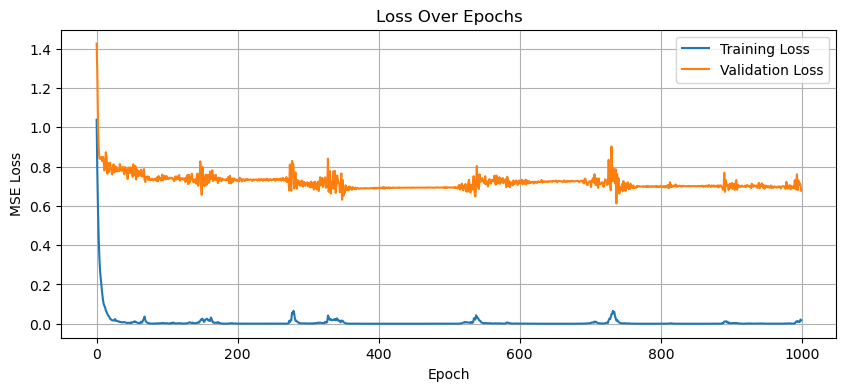

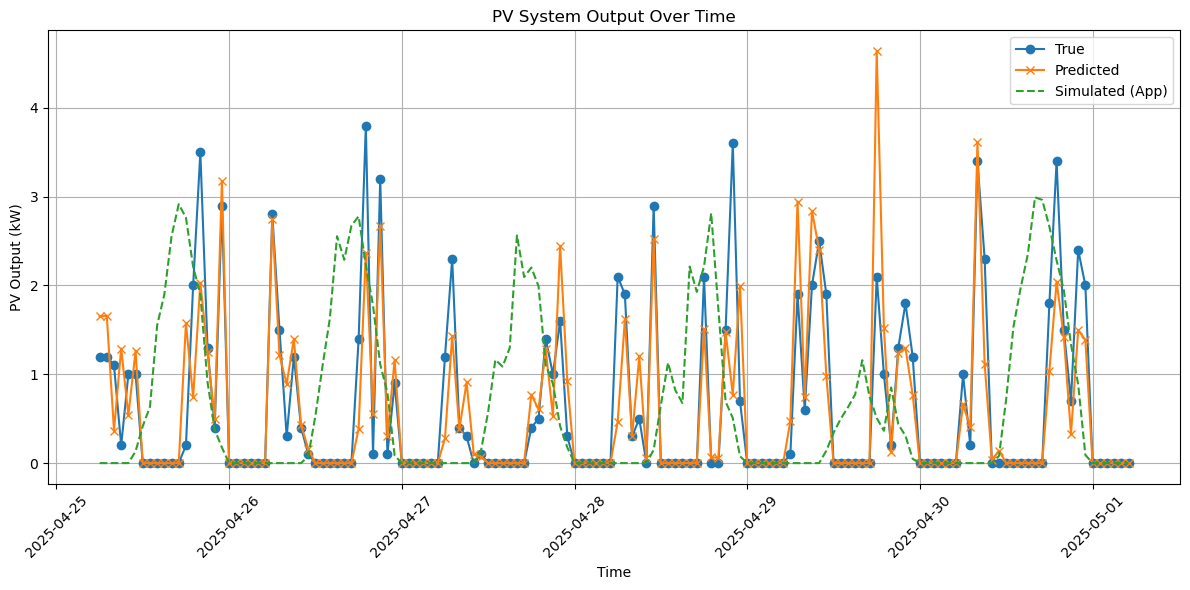

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures


X = np.column_stack((filtered_df_weather.to_numpy(), irradiation2))
# Display or process the filtered DataFrame
y=df_PV_Out.to_numpy()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # keep 95% of variance
X_pca = pca.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42,shuffle=True)



X_train_NN=np.copy(X_train)
X_test_NN=np.copy(X_test)

# Normalize Features
scaler = StandardScaler()
X_train_NN = scaler.fit_transform(X_train_NN)
X_test_NN = scaler.transform(X_test_NN)
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_quad = poly.fit_transform(X_train)
X_test_quad = poly.transform(X_test)
#Building the FFNN Model
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(100, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(
    X_train_NN, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    verbose=1
)

# Evaluating the Model
y_pred = model.predict(X_test_NN).flatten()
r2 = r2_score(y_test, y_pred)
print(f"\nTest R² Score: {r2:.4f}")

# Saving the Model Weights and Architecture using Pickle
os.makedirs("saved_models", exist_ok=True)

# Saving the model architecture (as a dictionary of layers and activation functions)
model_config = {
    "layers": [layer.get_config() for layer in model.layers],
    "weights": [layer.get_weights() for layer in model.layers]
}

# Save using pickle
with open("saved_models/dnn_model_with_PCA.pkl", "wb") as f:
    pickle.dump(model_config, f)
print("Model saved to 'saved_models/dnn_model_with_PCA.pkl'")

# Saving the Scaler using Pickle 
with open("saved_models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("Scaler saved to 'saved_models/scaler.pkl'")

X_train_NN_quad = np.copy(X_train_quad)
X_test_NN_quad = np.copy(X_test_quad)

# Normalize Features
scaler = StandardScaler()
X_train_NN_quad = scaler.fit_transform(X_train_NN_quad)
X_test_NN_quad = scaler.transform(X_test_NN_quad)

#Building the FFNN Model
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_quad.shape[1],)),
    Dense(64, activation='relu'),
    Dense(100, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

# --- Step 4: Compile ---
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(
    X_train_NN_quad, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    verbose=1
)

# Evaluating the Model
y_pred = model.predict(X_test_NN_quad).flatten()
r2 = r2_score(y_test, y_pred)
print(f"\nTest R² Score: {r2:.4f}")

# Saving the Model Weights and Architecture using Pickle
os.makedirs("saved_models", exist_ok=True)

# Saving the model architecture (as a dictionary of layers and activation functions)
model_config = {
    "layers": [layer.get_config() for layer in model.layers],
    "weights": [layer.get_weights() for layer in model.layers]
}

# Save using pickle
with open("saved_models/dnn_model.pkl", "wb") as f:
    pickle.dump(model_config, f)
print("Model saved to 'saved_models/quad_dnn_model.pkl'")

# Saving the Scaler using Pickle 
with open("saved_models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("Scaler saved to 'saved_models/quad_scaler.pkl'")


# --- Reshape and append zeros ---
y_test2 = y_test.reshape(12, -1)
y_pred2 = y_pred.reshape(12, -1)
y_test2 = np.column_stack((y_test2, np.zeros_like(y_test2)))  # Append zeros
y_pred2 = np.column_stack((y_pred2, np.zeros_like(y_pred2)))  # Append zeros
y_test2 = y_test2.flatten()
y_pred2 = y_pred2.flatten()

# --- Load external app data ---
df = pd.read_csv("Result_app.csv")
values = df['Inverter Power Input'].values
energy_production = np.array(values)
energy_production = np.roll(energy_production, 0)  # Shift by 6 hours

# --- Align lengths ---
min_length = min(len(y_test2), len(y_pred2), len(energy_production))
y_test2 = y_test2[:min_length]
print("For the Neural Network Model:")
RMSE_Pred = np.sqrt(np.mean((y_test2 - y_pred2) ** 2))
print(f"RMSE: {RMSE_Pred:.4f}")
RMSE_App=np.sqrt(np.mean((y_test2 - energy_production) ** 2))
print(f"RMSE_App: {RMSE_App:.4f}")
y_pred2 = y_pred2[:min_length]
energy_production = energy_production[:min_length]

# --- Create time index (e.g., starting at 6:00 AM) ---
time_index = pd.date_range(start="2025-04-25 06:00:00", periods=min_length, freq='H')

# --- Plot loss curves ---
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot time series predictions vs actuals ---
plt.figure(figsize=(12, 6))
plt.plot(time_index, y_test2, label='True', marker='o')
plt.plot(time_index, y_pred2, label='Predicted', marker='x')
plt.plot(time_index, energy_production, label='Simulated (App)', linestyle='--')
plt.title('PV System Output Over Time')
plt.xlabel('Time')
plt.ylabel('PV Output (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Testing and Comparing

             Time  Inverter Power Input
0  4/25/2007 0:00                   0.0
1  4/25/2007 1:00                   0.0
2  4/25/2007 2:00                   0.0
3  4/25/2007 3:00                   0.0
4  4/25/2007 4:00                   0.0


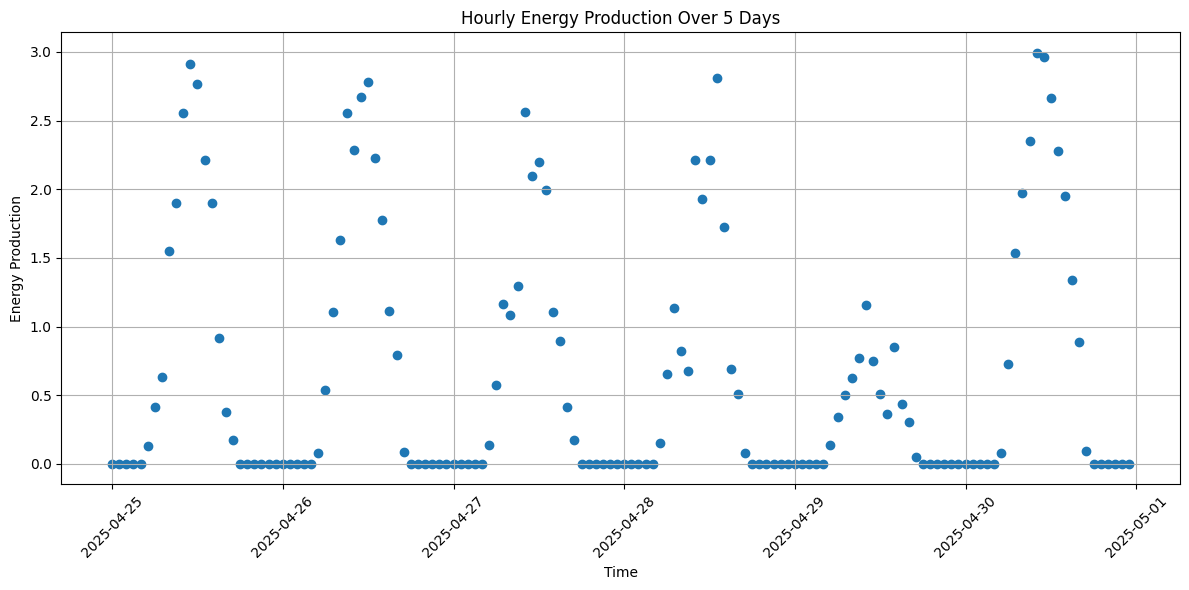

   Complexity       Loss               Equation
0           1  89.481964             0.15277047
1           2  20.446318         exp(2.1354747)
2           3  17.108137         36.612495 * x1
3           4  17.019350    sin(x1) * 37.128925
4           5  15.078956  (x20 - x2) + 22.08736


KeyError: 'lambda_format'

In [ ]:
# load a specific collumn from data.csv where the column is labeled "value", but my data has a header

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import csv

# Load the CSV file into a DataFrame
df = pd.read_csv("Result_app.csv")
# Display the first few rows of the DataFrame
print(df.head())
# Extract the 'value' column
values = df['Inverter Power Input'].values
length = len(values)
# Example: replace this with your actual data
energy_production = np.array(values)  # 120 hourly values

# Create a datetime index starting from a given date
start_time = pd.Timestamp("2025-04-25 00:00:00")
time_index = pd.date_range(start=start_time, periods=length, freq='H')

# Create a pandas Series for plotting
energy_series = pd.Series(energy_production, index=time_index)

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(energy_series.index, energy_series.values, marker='o')
plt.xlabel("Time")
plt.ylabel("Energy Production")
plt.title("Hourly Energy Production Over 5 Days")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
from pysr import PySRRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load the equations file (Hall of Fame CSV)
hof_df = pd.read_csv("hall_of_fame_2025-04-30_072024.829.csv")  # Adjust the filename if needed
print(hof_df.head())

# Choose the top model (index 0)
eq_str = hof_df.loc[0, "Equation"]
sympy_fn = eval(hof_df.loc[0, "lambda_format"])  # Turn string into Python function

# Apply model to X_test
y_pred = sympy_fn(X_test)

# Plot true vs predicted
plt.figure(figsize=(10, 4))
plt.plot(y_test, label="True", marker='o')
plt.plot(y_pred, label=f"Pred: {eq_str}\nR² = {r2_score(y_test, y_pred):.3f}", marker='x')
plt.xlabel("Sample Index")
plt.ylabel("Output")
plt.title("Top Symbolic Regression Model from Hall of Fame")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

def interleave_zeros_every_12(values, block_size=12, zeros_to_add=12):
    """Insert `zeros_to_add` zeros after every `block_size` values in the array."""
    values = np.array(values)
    output = []
    for i in range(0, len(values), block_size):
        output.extend(values[i:i+block_size])
        output.extend([0] * zeros_to_add)
    return np.array(output)

# Get the full list of discovered equations
top_equations = model.equations_.head(10)

# Loop through and plot each equation's predictions
for idx, row in top_equations.iterrows():
    eq_str = row["Equation"]
    sympy_fn = row["lambda_format"]  # This is a callable function

    try:
        # Evaluate the model using the symbolic function
        y_pred = sympy_fn(X_test)

        # Insert 12 zeros after every 12 values
        y_pred_interleaved = interleave_zeros_every_12(y_pred)

        # Pad y_test similarly to match shape
        y_test_interleaved = interleave_zeros_every_12(y_test[:len(y_pred)])  # truncate y_test if needed

        # Plot true vs predicted
        plt.figure(figsize=(10, 4))
        plt.plot(y_test_interleaved, label="True", marker='o')
        plt.plot(y_pred_interleaved, label=f"Pred: {eq_str}\nR² = {r2_score(y_test[:len(y_pred)], y_pred):.3f}", marker='x')
        plt.title(f"Equation {idx+1}")
        plt.xlabel("Test Sample Index")
        plt.ylabel("Output")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Skipping equation {idx+1} due to error: {e}")
